<a href="https://colab.research.google.com/github/twkang1987/DAT210x/blob/master/210401_prac04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\[SEP592\] 소프트웨어 특강 <데이터사이언스 입문>
# 5주차 실습 파트

> 강의일: 2021.04.01.

👤 실습담당자: 임채균 (KAIST 전산학부) &nbsp;&nbsp; | &nbsp;&nbsp; 📧 Email: rayote@kaist.ac.kr

---
<br />

#### &nbsp;&nbsp; *실습 목표*

*   Python을 활용해서 데이터셋을 다루는 방법을 확인함.
*   실제 <u>시계열 데이터</u>를 처리하는 과정을 통하여 기본적인 시계열 데이터 모델링을 학습함.



<br />

#### &nbsp;&nbsp; *References*

<!--
*   김태영, “블록과 함께 하는 파이썬 딥러닝 케라스,” 디지털
북스, 2017.
  * 김태영의 케라스 블로그 <small>https://tykimos.github.io/lecture/</small>
-->
*   `Prophet` Homepage. <small>http://facebook.github.io/prophet/</small>
*   `Prophet` Official Documentation - Diagnostics. <small>https://facebook.github.io/prophet/docs/diagnostics.html</small>
*   `Pandas` Homepage. <small>https://pandas.pydata.org/</small>
*   Taylor, Sean J., and Benjamin Letham. "Forecasting at scale." The American Statistician 72.1 (2018): 37-45. <small>https://www.tandfonline.com/doi/pdf/10.1080/00031305.2017.1380080</small>
*   
Jennifer Walker, "Tutorial: Time Series Analysis with Pandas," Jan. 10, 2019. <small>https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/</small>
*   Winston Robson, "Intro to Facebook Prophet," Jul. 9, 2019. <small>https://medium.com/future-vision/intro-to-prophet-9d5b1cbd674e</small>

<br />

---

## 시계열 데이터셋: Open Power Systems Data (OPSD)

[Daily time series of Open Power System Data (OPSD)](https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv) for Germany, which has been rapidly expanding its renewable energy production in recent years.

Electricity production and consumption are reported as <u>*daily totals in gigawatt-hours (GWh)*</u> from `2016-01-01` to `2017-12-31`. 

The columns of the data file are:
* `Date` — The date (yyyy-mm-dd format)
* `Consumption` — Electricity consumption in GWh
* `Wind` — Wind power production in GWh
* `Solar` — Solar power production in GWh
* `Wind+Solar` — Sum of wind and solar power production in GWh

In [1]:
# 데이터셋 경로
url_daily_opsd = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

Colab 런타임 환경에서, `!`로 시작하는 구문으로 리눅스 명령어를 활용 가능함.

(e.g.) `curl` 명령어로 데이터셋 일부분 미리보기

*   `-r 0-399` : 해당 URL의 웹페이지를 0 ~ 399 Byte 범위만 로드
*   `{url_daily_opsd}` : Colab 런타임 환경에서 선언된 Python 변수를 참조할 때 중괄호 `{ }`를 사용
*   실행결과로 CSV (Comma-Separated Values) 형식의 데이터 확인 가능

In [2]:
!curl -r 0-399 {url_daily_opsd}

Date,Consumption,Wind,Solar,Wind+Solar
2006-01-01,1069.1840000000002,,,
2006-01-02,1380.5210000000002,,,
2006-01-03,1442.5330000000001,,,
2006-01-04,1457.2169999999999,,,
2006-01-05,1477.131,,,
2006-01-06,1403.4270000000001,,,
2006-01-07,1300.2870000000003,,,
2006-01-08,1207.9849999999997,,,
2006-01-09,1529.3229999999996,,,
2006-01-10,1576.911,,,
2006-01-11,1577.1759999999997,,,
2006-01-12,1553.28

## **1. Pyhton을 통한 데이터 활용** (Pandas 모듈)


**`pandas`** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, 

built on top of the Python programming language.

#### Pandas 설치여부 확인

In [3]:
!pip show pandas

Name: pandas
Version: 1.1.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, pytz, python-dateutil
Required-by: xarray, vega-datasets, statsmodels, sklearn-pandas, seaborn, pymc3, plotnine, pandas-profiling, pandas-gbq, pandas-datareader, mlxtend, mizani, holoviews, gspread-dataframe, google-colab, fix-yahoo-finance, fbprophet, fastai, cufflinks, cmdstanpy, altair


#### Pandas 모듈 임포트

In [4]:
import pandas as pd

In [5]:
help(pd)

Help on package pandas:

NAME
    pandas

DESCRIPTION
    pandas - a powerful data analysis and manipulation library for Python
    
    **pandas** is a Python package providing fast, flexible, and expressive data
    structures designed to make working with "relational" or "labeled" data both
    easy and intuitive. It aims to be the fundamental high-level building block for
    doing practical, **real world** data analysis in Python. Additionally, it has
    the broader goal of becoming **the most powerful and flexible open source data
    analysis / manipulation tool available in any language**. It is already well on
    its way toward this goal.
    
    Main Features
    -------------
    Here are just a few of the things that pandas does well:
    
      - Easy handling of missing data in floating point as well as non-floating
        point data.
      - Size mutability: columns can be inserted and deleted from DataFrame and
        higher dimensional objects
      - Automatic an

#### 데이터셋 로드

`read_csv()` 함수로 OPSD 데이터 로드

*   `URL` : 해당 경로의 웹페이지에서 Raw 데이터를 직접 사용
*   `sep` : 데이터의 구분자(delimiter) 표기 <br />
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
  (e.g.) 콤마(`,`), 공백문자(` `), 탭 문자(`\t`) 등
*   `index_col` : 데이터에서 인덱스로 지정할 column id
*   `parse_dates` : 타임스탬프(timestamp) 정보로 해석할 column id
*   실행결과로 `DataFrame` 객체를 리턴

In [6]:
df_opsd = pd.read_csv(url_daily_opsd, 
                      sep= ',', 
                      index_col= 0,
                      parse_dates= [0])

#### 데이터셋 내용 확인

In [7]:
df_opsd

Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400      NaN     NaN         NaN
2006-01-02   1380.52100      NaN     NaN         NaN
2006-01-03   1442.53300      NaN     NaN         NaN
2006-01-04   1457.21700      NaN     NaN         NaN
2006-01-05   1477.13100      NaN     NaN         NaN
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]

`head()` 함수로 데이터셋의 **앞부분**만 출력

* `n` : 선택할 데이터 개수 (default: 5)

In [8]:
df_opsd.head()

Consumption  Wind  Solar  Wind+Solar
Date                                            
2006-01-01     1069.184   NaN    NaN         NaN
2006-01-02     1380.521   NaN    NaN         NaN
2006-01-03     1442.533   NaN    NaN         NaN
2006-01-04     1457.217   NaN    NaN         NaN
2006-01-05     1477.131   NaN    NaN         NaN

`tail()` 함수로 데이터셋의 **뒷부분**만 출력 

* `n` : 선택할 데이터 개수 (default: 5)

In [9]:
df_opsd.tail(8)

Consumption     Wind   Solar  Wind+Solar
Date                                                
2017-12-24   1141.75730  812.422   9.949     822.371
2017-12-25   1111.28338  587.810  15.765     603.575
2017-12-26   1130.11683  717.453  30.923     748.376
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

데이터셋의 `index` 목록을 확인

In [10]:
df_opsd.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

데이터셋의 `column` 목록을 확인

In [11]:
df_opsd.columns

Index(['Consumption', 'Wind', 'Solar', 'Wind+Solar'], dtype='object')

#### 데이터 통계 요약

`describe()` 함수로 데이터의 주요 통계값을 계산

In [12]:
df_opsd.describe()

Consumption         Wind        Solar   Wind+Solar
count  4383.000000  2920.000000  2188.000000  2187.000000
mean   1338.675836   164.814173    89.258695   272.663481
std     165.775710   143.692732    58.550099   146.319884
min     842.395000     5.757000     1.968000    21.478000
25%    1217.859000    62.353250    35.179250   172.185500
50%    1367.123000   119.098000    86.407000   240.991000
75%    1457.761000   217.900250   135.071500   338.988000
max    1709.568000   826.278000   241.580000   851.556000

#### 데이터의 일부분 선택

##### **(1) `DataFrame`에서 직접 선택**

특정한 `column` 기준으로 선택 (`Series` 객체를 리턴)

In [13]:
df_opsd['Solar']

Date
2006-01-01       NaN
2006-01-02       NaN
2006-01-03       NaN
2006-01-04       NaN
2006-01-05       NaN
               ...  
2017-12-27    16.530
2017-12-28    14.162
2017-12-29    29.854
2017-12-30     7.467
2017-12-31    19.980
Name: Solar, Length: 4383, dtype: float64

특정 지점의 행을 기준으로 slice하여 선택

In [14]:
# 범위는 0번부터 시작
# 선택 범위 : 시작 번호 이상, 종료 번호 미만
#     (e.g.) [0:3] 인 경우에는 0, 1, 2 의 3개를 선택
df_opsd[0:3]

Consumption  Wind  Solar  Wind+Solar
Date                                            
2006-01-01     1069.184   NaN    NaN         NaN
2006-01-02     1380.521   NaN    NaN         NaN
2006-01-03     1442.533   NaN    NaN         NaN

In [15]:
# 시작 번호 생략 시, 0번으로 취급
df_opsd[:3]

Consumption  Wind  Solar  Wind+Solar
Date                                            
2006-01-01     1069.184   NaN    NaN         NaN
2006-01-02     1380.521   NaN    NaN         NaN
2006-01-03     1442.533   NaN    NaN         NaN

In [16]:
# 음수 표현으로 마지막 번호부터 n개 선택 가능
df_opsd[-5:]

Consumption     Wind   Solar  Wind+Solar
Date                                                
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

##### **(2) `loc` 프로퍼티 활용**

`loc` 프로퍼티를 이용하여 `DataFrame`의 인덱스를 기준으로 범위 선택 가능함.

In [17]:
# 특정 row의 인덱스를 지정하면, 해당 데이터 항목을 Series 객체로 리턴
a = df_opsd.loc['20120505']

type(a)

pandas.core.series.Series

In [18]:
a

Consumption    1131.952
Wind             51.582
Solar            70.418
Wind+Solar      122.000
Name: 2012-05-05 00:00:00, dtype: float64

In [19]:
# 이 경우에서, 대괄호 [ ]를 2중첩하면 DataFrame 객체로 리턴
b = df_opsd.loc[['20120505']]

type(b)

pandas.core.frame.DataFrame

In [20]:
b

Consumption    Wind   Solar  Wind+Solar
Date                                               
2012-05-05     1131.952  51.582  70.418       122.0

In [21]:
# 특정 rows의 범위를 지정 가능
# 이 경우에는 마지막 종료 범위도 포함됨
df_opsd.loc['20120505':'20120509']

Consumption    Wind    Solar  Wind+Solar
Date                                                
2012-05-05     1131.952  51.582   70.418     122.000
2012-05-06     1044.236  29.245   65.151      94.396
2012-05-07     1359.119  16.205   94.130     110.335
2012-05-08     1354.063  84.137  143.577     227.714
2012-05-09     1375.723  97.102   97.601     194.703

In [22]:
# 특정 columns을 지정 가능
# 콜론(:) 표기는 row의 전체 범위를 의미
df_opsd.loc[:, ['Consumption', 'Solar']]

Consumption   Solar
Date                           
2006-01-01   1069.18400     NaN
2006-01-02   1380.52100     NaN
2006-01-03   1442.53300     NaN
2006-01-04   1457.21700     NaN
2006-01-05   1477.13100     NaN
...                 ...     ...
2017-12-27   1263.94091  16.530
2017-12-28   1299.86398  14.162
2017-12-29   1295.08753  29.854
2017-12-30   1215.44897   7.467
2017-12-31   1107.11488  19.980

[4383 rows x 2 columns]

In [23]:
# 특정 columns 및 row를 동시에 지정
df_opsd.loc['20120505':'20120509', ['Consumption', 'Solar']]

Consumption    Solar
Date                            
2012-05-05     1131.952   70.418
2012-05-06     1044.236   65.151
2012-05-07     1359.119   94.130
2012-05-08     1354.063  143.577
2012-05-09     1375.723   97.601

In [24]:
# 특정 cell의 데이터값 접근 (scholar값 리턴)
c = df_opsd.loc['20120505', 'Solar']

type(c)

numpy.float64

In [25]:
c

70.418

##### **(3) `iloc` 프로퍼티 활용**

`iloc` 프로퍼티를 사용하여 **인덱스 번호** 기준으로 선택 가능

In [26]:
# 범위는 0번부터 시작
# 특정 row의 번호를 지정하면 Series 객체를 리턴
df_opsd.iloc[0]

Consumption    1069.184
Wind                NaN
Solar               NaN
Wind+Solar          NaN
Name: 2006-01-01 00:00:00, dtype: float64

In [27]:
# 선택 범위 : 시작 번호 이상, 종료 번호 미만
#     (e.g.) [0:3] 인 경우에는 0, 1, 2 의 3개를 선택
df_opsd.iloc[0:3]

Consumption  Wind  Solar  Wind+Solar
Date                                            
2006-01-01     1069.184   NaN    NaN         NaN
2006-01-02     1380.521   NaN    NaN         NaN
2006-01-03     1442.533   NaN    NaN         NaN

In [28]:
# 특정 colums의 번호를 지정 가능
df_opsd.iloc[:, [0, 2]]

Consumption   Solar
Date                           
2006-01-01   1069.18400     NaN
2006-01-02   1380.52100     NaN
2006-01-03   1442.53300     NaN
2006-01-04   1457.21700     NaN
2006-01-05   1477.13100     NaN
...                 ...     ...
2017-12-27   1263.94091  16.530
2017-12-28   1299.86398  14.162
2017-12-29   1295.08753  29.854
2017-12-30   1215.44897   7.467
2017-12-31   1107.11488  19.980

[4383 rows x 2 columns]

In [29]:
# 특정 row 및 colums의 번호를 동시에 지정 가능
df_opsd.iloc[0:3, 1:4]

Wind  Solar  Wind+Solar
Date                               
2006-01-01   NaN    NaN         NaN
2006-01-02   NaN    NaN         NaN
2006-01-03   NaN    NaN         NaN

In [30]:
# 특정 cell을 인덱스 번호로 지정
df_opsd.iloc[-1, 2]

19.98

##### **(4) Boolean 기준으로 선택**

조건문을 활용하여 데이터 항목을 선택 가능

In [31]:
# 임시 데이터 slice
df0 = df_opsd[-100:]

df0

Consumption     Wind    Solar  Wind+Solar
Date                                                 
2017-09-23   1191.10345   28.878  117.186     146.064
2017-09-24   1115.07288   53.474   88.861     142.335
2017-09-25   1419.59171  104.591   91.453     196.044
2017-09-26   1445.40606  139.101  102.238     241.339
2017-09-27   1451.00792  144.547  108.037     252.584
...                 ...      ...      ...         ...
2017-12-27   1263.94091  394.507   16.530     411.037
2017-12-28   1299.86398  506.424   14.162     520.586
2017-12-29   1295.08753  584.277   29.854     614.131
2017-12-30   1215.44897  721.247    7.467     728.714
2017-12-31   1107.11488  721.176   19.980     741.156

[100 rows x 4 columns]

In [32]:
# 'Solar'의 값이 8 미만인 데이터 선택
df0[df0['Solar'] < 8]

Consumption     Wind  Solar  Wind+Solar
Date                                               
2017-12-06   1639.08265  632.501  7.618     640.119
2017-12-11   1614.15862  415.109  5.669     420.778
2017-12-21   1520.37206  259.039  7.313     266.352
2017-12-30   1215.44897  721.247  7.467     728.714

In [33]:
# 전체 DataFrame에 대해서 조건문 적용 가능
# 조건이 만족되지 않는 cell의 경우에는 `NaN` 값이 할당됨
df0[df0 > 100]

Consumption     Wind    Solar  Wind+Solar
Date                                                 
2017-09-23   1191.10345      NaN  117.186     146.064
2017-09-24   1115.07288      NaN      NaN     142.335
2017-09-25   1419.59171  104.591      NaN     196.044
2017-09-26   1445.40606  139.101  102.238     241.339
2017-09-27   1451.00792  144.547  108.037     252.584
...                 ...      ...      ...         ...
2017-12-27   1263.94091  394.507      NaN     411.037
2017-12-28   1299.86398  506.424      NaN     520.586
2017-12-29   1295.08753  584.277      NaN     614.131
2017-12-30   1215.44897  721.247      NaN     728.714
2017-12-31   1107.11488  721.176      NaN     741.156

[100 rows x 4 columns]

`isin()` 함수로 주어진 항목들에 대해 필터링

In [34]:
# 인덱스에 대한 필터링
filter = ['20170926', '20171005', '20171122']

df0[df0.index.isin(filter)]

Consumption     Wind    Solar  Wind+Solar
Date                                                 
2017-09-26   1445.40606  139.101  102.238     241.339
2017-10-05   1480.53577  742.246   70.285     812.531
2017-11-22   1558.72998  588.234   46.147     634.381

In [35]:
# 특정 column에 대한 필터링
filter = [7.313, 5.669]

df0[df0['Solar'].isin(filter)]

Consumption     Wind  Solar  Wind+Solar
Date                                               
2017-12-11   1614.15862  415.109  5.669     420.778
2017-12-21   1520.37206  259.039  7.313     266.352

#### Missing value 처리

*(참고)* 데이터셋 내용 확인

In [36]:
df_opsd

Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400      NaN     NaN         NaN
2006-01-02   1380.52100      NaN     NaN         NaN
2006-01-03   1442.53300      NaN     NaN         NaN
2006-01-04   1457.21700      NaN     NaN         NaN
2006-01-05   1477.13100      NaN     NaN         NaN
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]

`fillna()` 함수로 특정 값을 일괄적으로 할당

In [37]:
df_opsd.fillna(0)

Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400    0.000   0.000       0.000
2006-01-02   1380.52100    0.000   0.000       0.000
2006-01-03   1442.53300    0.000   0.000       0.000
2006-01-04   1457.21700    0.000   0.000       0.000
2006-01-05   1477.13100    0.000   0.000       0.000
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]

`dropna()` 함수로 `NaN`을 포함하는 데이터 row를 제거

In [38]:
df_opsd.dropna()

Consumption     Wind   Solar  Wind+Solar
Date                                                
2012-01-01    948.12800  227.465   6.587     234.052
2012-01-02   1269.58100  207.327   6.574     213.901
2012-01-03   1334.74500  473.468  24.679     498.147
2012-01-04   1347.13600  499.804  14.681     514.485
2012-01-05   1376.65800  523.851   5.071     528.922
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[2187 rows x 4 columns]

`isna()` 함수로 `NaN` 인 경우는 True, 어떤 값을 가진 경우는 False로 표시 가능함.

In [39]:
df_opsd.isna()

Consumption   Wind  Solar  Wind+Solar
Date                                             
2006-01-01        False   True   True        True
2006-01-02        False   True   True        True
2006-01-03        False   True   True        True
2006-01-04        False   True   True        True
2006-01-05        False   True   True        True
...                 ...    ...    ...         ...
2017-12-27        False  False  False       False
2017-12-28        False  False  False       False
2017-12-29        False  False  False       False
2017-12-30        False  False  False       False
2017-12-31        False  False  False       False

[4383 rows x 4 columns]

#### 데이터 시각화

In [40]:
# 임시 데이터 slice
df0 = df_opsd.loc['20130101':'20131231']

df0

Consumption     Wind   Solar  Wind+Solar
Date                                                
2013-01-01      906.910  262.438  14.218     276.656
2013-01-02     1160.174  224.867  26.010     250.877
2013-01-03     1199.565  387.143   6.058     393.201
2013-01-04     1198.952  342.443   4.976     347.419
2013-01-05     1108.271  140.410   4.970     145.380
...                 ...      ...     ...         ...
2013-12-27     1166.552  395.736  41.011     436.747
2013-12-28     1089.790  208.514  21.028     229.542
2013-12-29     1031.149  213.978  20.933     234.911
2013-12-30     1149.097  254.119  47.097     301.216
2013-12-31     1068.429  174.670  43.219     217.889

[365 rows x 4 columns]

##### (1) 단일 그래프 출력

`plot()` 함수로 데이터를 그래프 형태로 출력

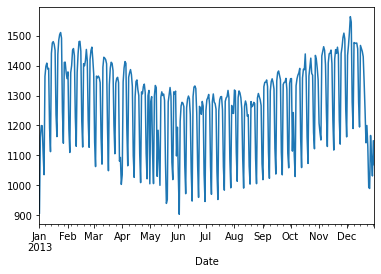

In [41]:
# 그래프 출력의 기본 형태
df0['Consumption'].plot()

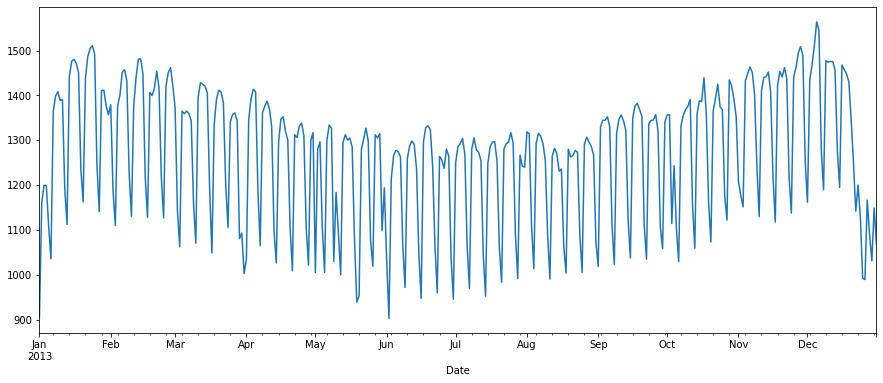

In [42]:
# Figure size 파라미터 추가
df0['Consumption'].plot(figsize= (15, 6))

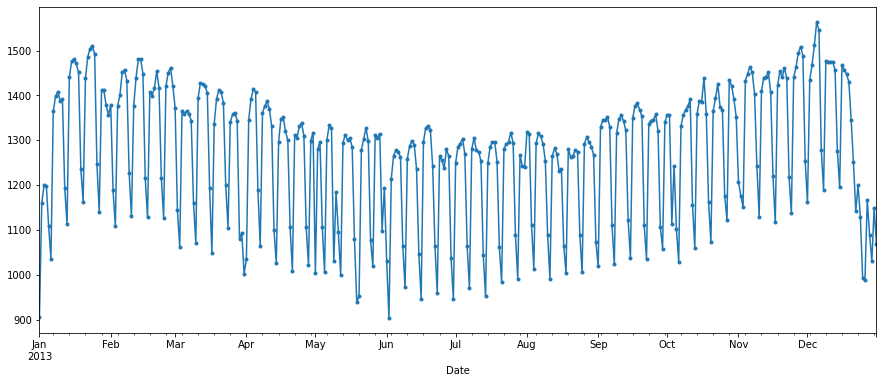

In [43]:
# marker 추가
# 종류: 마침표(.), 언더바(_),  알파벳 소문자 o, x, v(trianlge), s(square) 등
df0['Consumption'].plot(figsize= (15, 6), 
                        marker= '.')

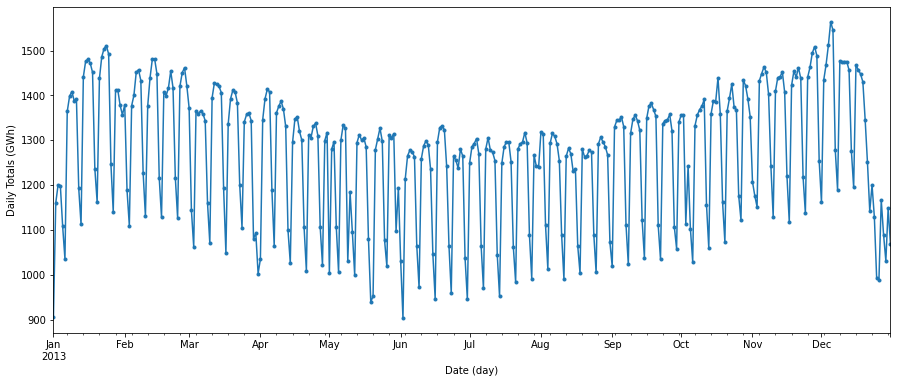

In [44]:
# 그래프 타이틀 및 X, Y축의 레이블 지정 가능
df0['Consumption'].plot(figsize= (15, 6), 
                        marker= '.', 
                        xlabel= 'Date (day)', # DataFrame 인덱스 명칭이 기본값
                        ylabel= 'Daily Totals (GWh)')

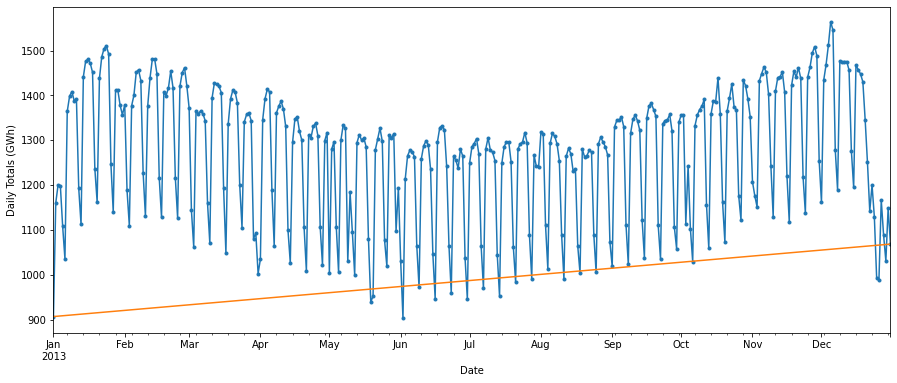

In [45]:
df0['Consumption'].plot(figsize= (15, 6), 
                        marker= '.', 
                        xlabel= 'Date (day)', 
                        ylabel= 'Daily Totals (GWh)')

# 현재 plot에 다른 그래프 추가
# (e.g., 첫번째 및 마지막 데이터만 선택하여 line으로 그린 것)
df0['Consumption'].iloc[[0, -1]].plot()

##### (2) 여러 그래프의 `subplot` 출력

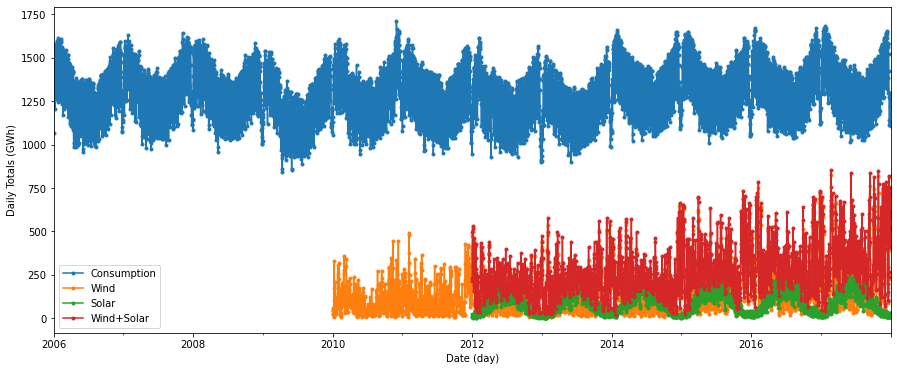

In [46]:
# DataFrame의 모든 내용을 시각화 (i.e., 특정 column을 지정하지 않음)
df_opsd.plot(figsize= (15, 6), 
             marker= '.', 
             xlabel= 'Date (day)', 
             ylabel= 'Daily Totals (GWh)')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1a1f487d0>,
      dtype=object)

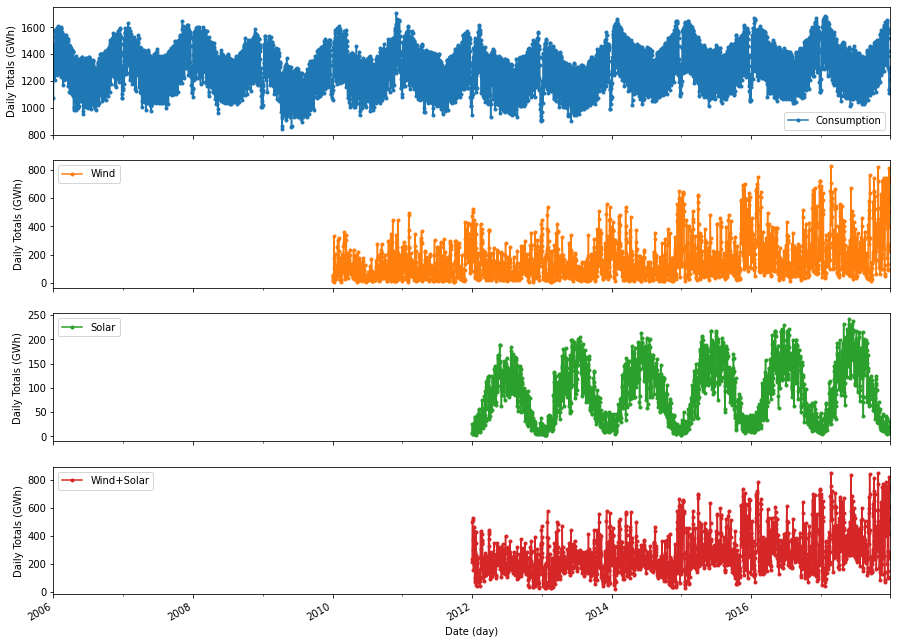

In [47]:
# `subplot` 파라미터 추가
df_opsd.plot(figsize= (15, 12), # 그래프 높이 확대
             marker= '.', 
             xlabel= 'Date (day)', 
             ylabel= 'Daily Totals (GWh)',
             subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a0f3e3110>,
      dtype=object)

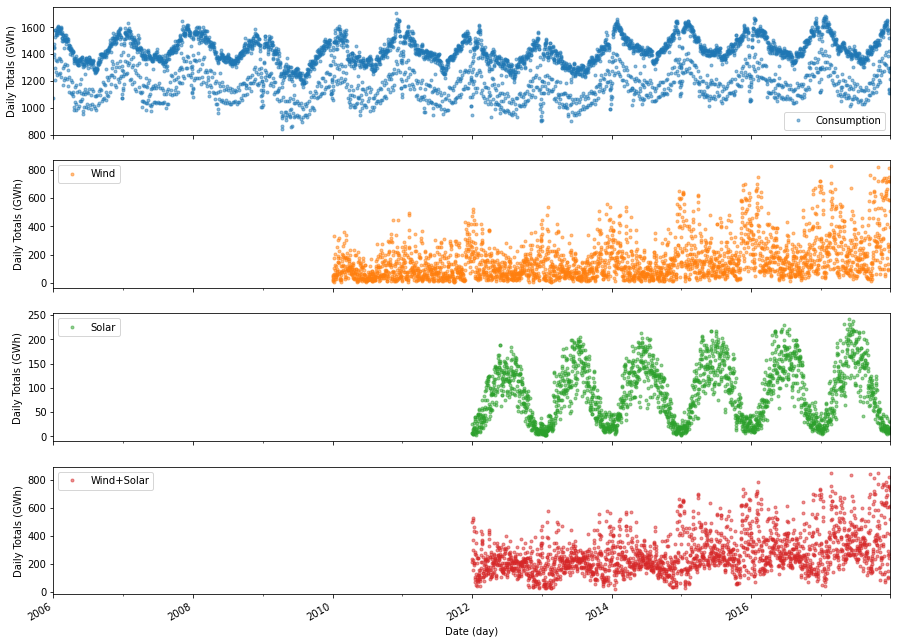

In [48]:
# `linestyle` 제거하고, `alpha` 값으로 투명도 50% 추가
df_opsd.plot(figsize= (15, 12), 
             marker= '.', 
             xlabel= 'Date (day)', 
             ylabel= 'Daily Totals (GWh)',
             subplots=True,
             linestyle='None', 
             alpha=0.5)

## **2. 시계열 데이터 처리** (Prophet 모듈)




**`Prophet`** is a forecasting procedure implemented in  R and Python.  

It is fast and provides completely automated forecasts that can be tuned by hand by data scientists and analysts.

*(Open-sourced by **Facebook** in `February 2017`)*

<br />

`Prophet` was intentionally designed to lower the cost of entry for “analysts” — who possess an “in-the-loop” understanding of the problems they are trying to solve — via automation of time series forecasting.

![Workflow of Prophet](https://miro.medium.com/max/368/1*0B5XZPvI_oDOCcnq_0QsSA.png)

<br />

A <u>decomposable time series model</u> with three main model components: *trend*, *seasonality*, and *holidays*.

> $y(t) = g(t) + s(t) + h(t) + e_t$

*   $g(t)$  
  - **Trend** models non-periodic changes; linear or logistic

*   $s(t)$
  - **Seasonality** represents periodic changes; i.e. weekly, monthly, yearly

*   $h(t)$
  - ties in effects of **holidays**; on potentially irregular schedules ≥ 1 day(s)

#### Prophet 설치여부 확인

In [49]:
!pip show fbprophet

Name: fbprophet
Version: 0.7.1
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: Sean J. Taylor <sjtz@pm.me>, Ben Letham <bletham@fb.com>
Author-email: sjtz@pm.me
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: Cython, cmdstanpy, pystan, numpy, pandas, matplotlib, LunarCalendar, convertdate, holidays, setuptools-git, python-dateutil, tqdm
Required-by: 


#### Prophet 모듈 임포트

In [50]:
from fbprophet import Prophet

In [51]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

#### 기본적인 사용 방법

Prophet을 사용하려면 Dataframe 구조를 "`ds`", "`y`" 로 일치시켜야 함.

The input to Prophet is always a dataframe with two columns: `ds` and `y`. 

*   The `ds` (datestamp) column should be of a format expected by Pandas, ideally `YYYY-MM-DD` for a date or `YYYY-MM-DD HH:MM:SS` for a timestamp. 
*   The `y` column must be numeric, and represents the measurement we wish to forecast.


In [52]:
# 신규 객체
df0 = pd.DataFrame()

# 2010~2012년 범위에서 'Consumption' 데이터만 발췌
df0['ds'] = df_opsd.loc['20100101':'20121231'].index
df0['y'] = df_opsd.loc['20100101':'20121231', 'Consumption'].values

df0.tail()

ds         y
1091 2012-12-27  1068.617
1092 2012-12-28  1109.424
1093 2012-12-29  1014.550
1094 2012-12-30   936.786
1095 2012-12-31   969.810

In [53]:
# Prophet 모델 생성
m = Prophet() # Default growth='linear'

# 시계열 데이터 적용
m.fit(df0)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
# 미래 예측할 날짜범위 생성 (i.e., 다음 1년 분량)
future = m.make_future_dataframe(periods=365)
future.tail()

ds
1456 2013-12-27
1457 2013-12-28
1458 2013-12-29
1459 2013-12-30
1460 2013-12-31

In [55]:
# 미래 범위만큼 예측 수행 (i.e., 다음 1년 분량)
forecast = m.predict(future)
forecast.tail()

ds        trend  ...  multiplicative_terms_upper         yhat
1456 2013-12-27  1148.586233  ...                         0.0  1139.108528
1457 2013-12-28  1148.332444  ...                         0.0   934.306033
1458 2013-12-29  1148.078655  ...                         0.0   829.721951
1459 2013-12-30  1147.824867  ...                         0.0  1118.181539
1460 2013-12-31  1147.571078  ...                         0.0  1161.696821

[5 rows x 19 columns]

시각화 그래프에서 `Uncertainty Intervals`은 <u>연한 하늘색</u> 범위로 표현됨.

* 불확실성(Uncertainty)의 범위가 나타나는 원인
  - Trend의 불확실성
  - Seasonality 추정의 불확실성
  - 추가 관찰되는 잡음(nosie)

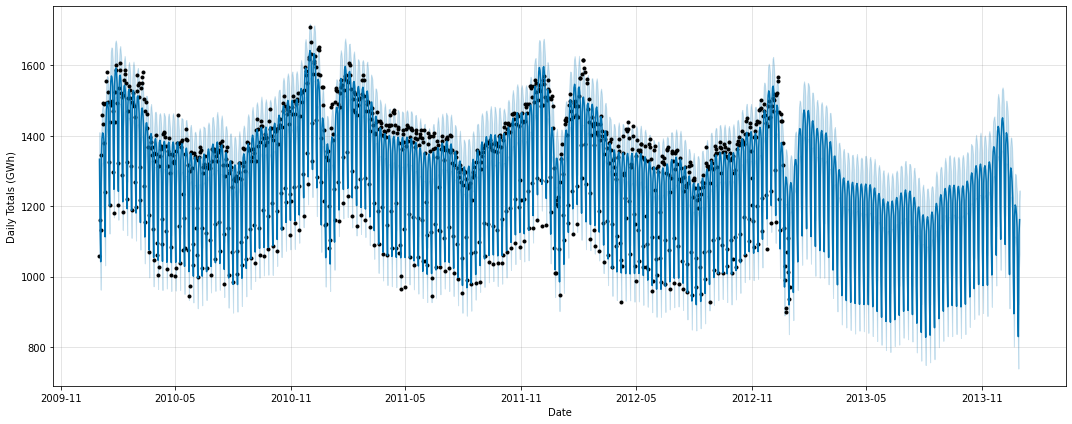

In [56]:
# 예측결과 그래프 출력
fig = m.plot(forecast, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')

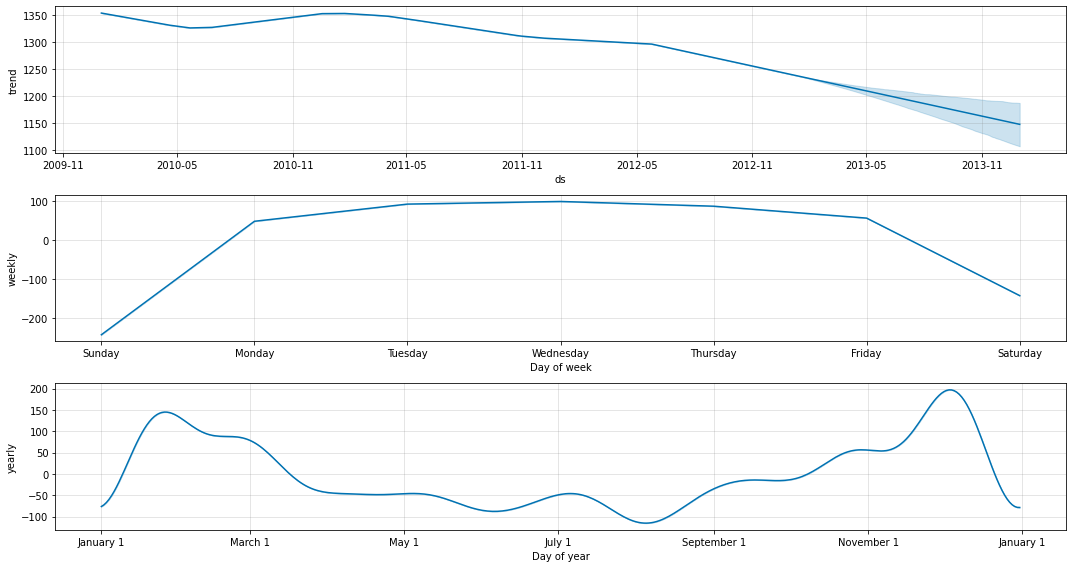

In [57]:
# 메인 컴포넌트(trend, weekly, yearly) 출력
fig2 = m.plot_components(forecast, 
                         figsize= (15, 8))

#### 시계열 데이터의 특성 분석

##### **(1) Trend**

`add_changepoints_to_plot()` 함수로 시계열 데이터의 trend 변화를 확인

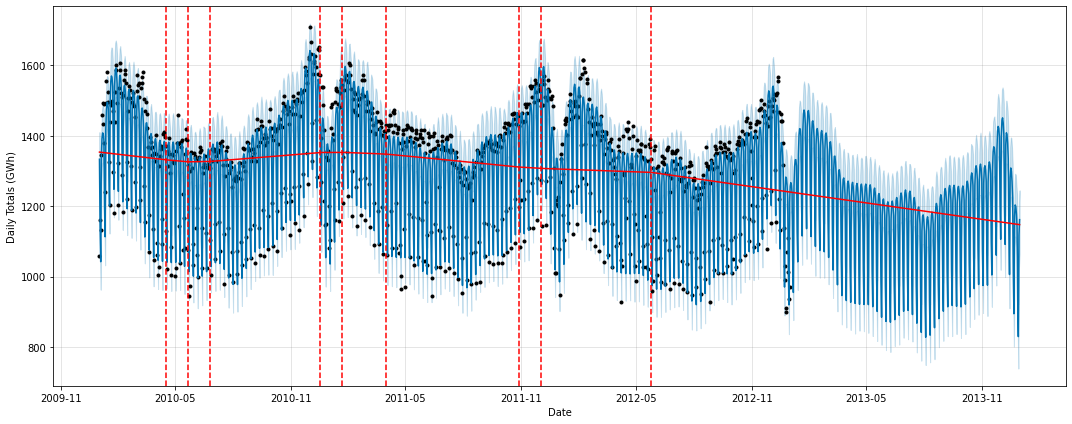

In [58]:
from fbprophet.plot import add_changepoints_to_plot

# 예측결과 그래프 출력
fig = m.plot(forecast, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')

# trend 변화 추가
a = add_changepoints_to_plot(fig.gca(), m, forecast)

`Prophet` 모델을 처음 생성할 때, trend의 변화를 자동추출하는 비중을 조절할 수 있음.

*   `changepoint_prior_scale` : trend 변화의 자동추출 비중 (default= 0.05)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


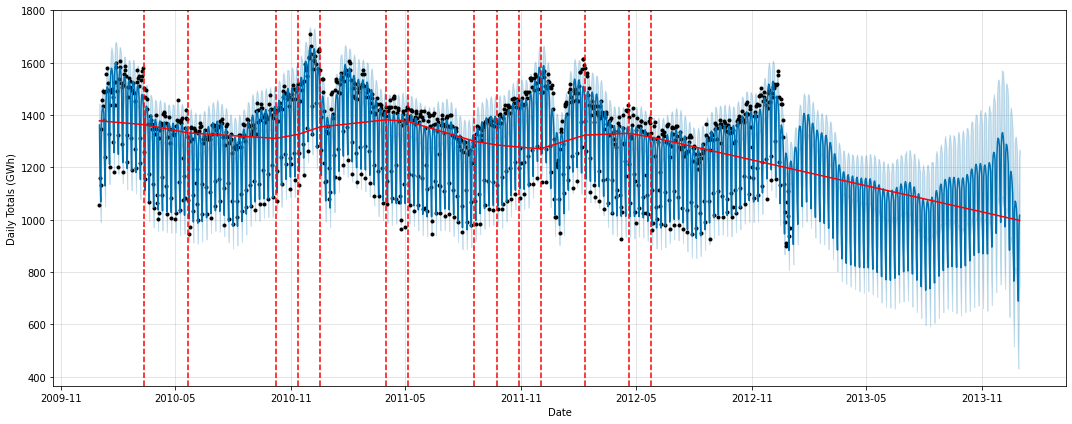

In [59]:
# `Prophet` 모델 재생성
m = Prophet(changepoint_prior_scale=0.3)
m.fit(df0)

# 미래값 예측
forecast = m.predict(future)

# 예측결과 그래프 출력
fig = m.plot(forecast, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')

# trend 변화 추가
a = add_changepoints_to_plot(fig.gca(), m, forecast)

##### **(2) Seasonality**

`Prophet` 모델을 처음 생성할 때, seasonality에 대한 비중을 조절할 수 있으며 3가지 종류(yearly, weekly, daily)로 구분됨.

*   `yearly_seasonality` : Fit yearly seasonality. <br />
    Can be `'auto'`, `True`, `False`, or a number of Fourier terms to generate.
*   `weekly_seasonality` : Fit weekly seasonality. <br />
    Can be `'auto'`, `True`, `False`, or a number of Fourier terms to generate.
*   `daily_seasonality` : Fit daily seasonality. <br />
    Can be `'auto'`, `True`, `False`, or a number of Fourier terms to generate.

In [60]:
# yearly component만 개별 출력하기 위한 모듈 임포트
from fbprophet.plot import plot_yearly

*(참고) 기본 모델의 yearly component

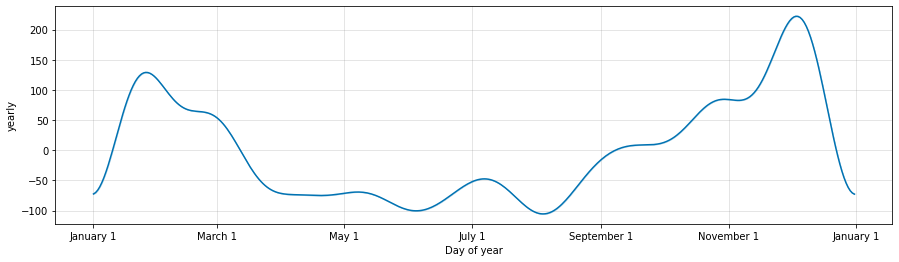

In [61]:
# 기본 모델
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=3,  # (default= 3)
    yearly_seasonality=10, # (default= 10)
    daily_seasonality=False
)
m.fit(df0)
forecast = m.predict(future)

fig = plot_yearly(m, figsize= (15, 4))

기본 모델에 비해서, 상대적으로 더 디테일한 yearly 변화를 반영하게 되었음.

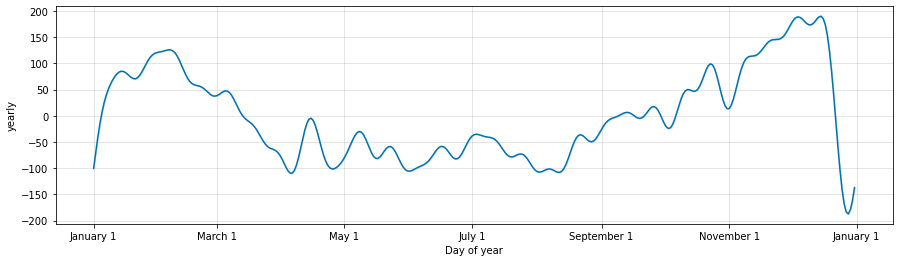

In [62]:
# seasonality 비중을 높인 모델 (yearly=30 으로 설정)
m2 = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=3,  # (default= 3)
    yearly_seasonality=30, # (default= 10)
    daily_seasonality=False
)

m2.fit(df0)
forecast2 = m.predict(future)

fig2 = plot_yearly(m2, figsize= (15, 4))

2개 모델의 전반적인 추세를 다시 확인해 본 결과로, 
trend 관점에서도 yearly의 디테일한 굴곡에 따라 changepoint가 변화한 것을 알 수 있음.

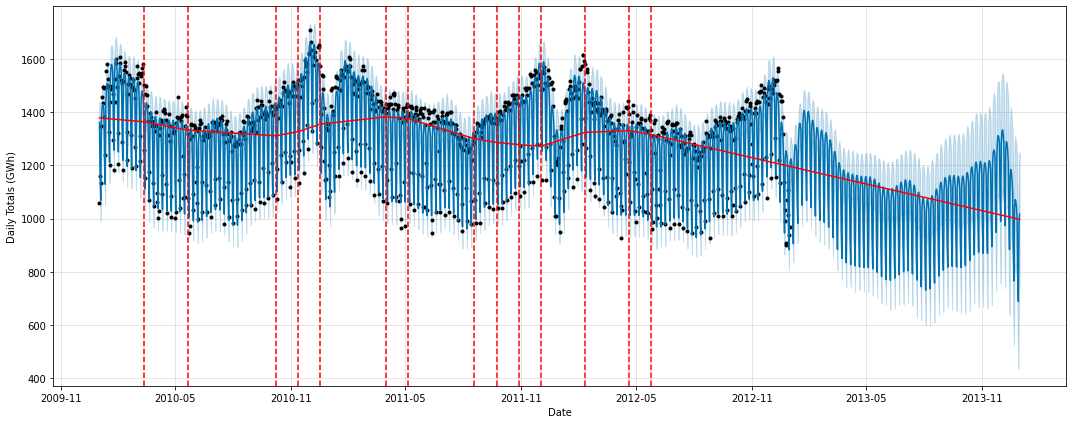

In [63]:
# 기본모델의 그래프 출력
fig = m.plot(forecast, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')
a = add_changepoints_to_plot(fig.gca(), m, forecast)

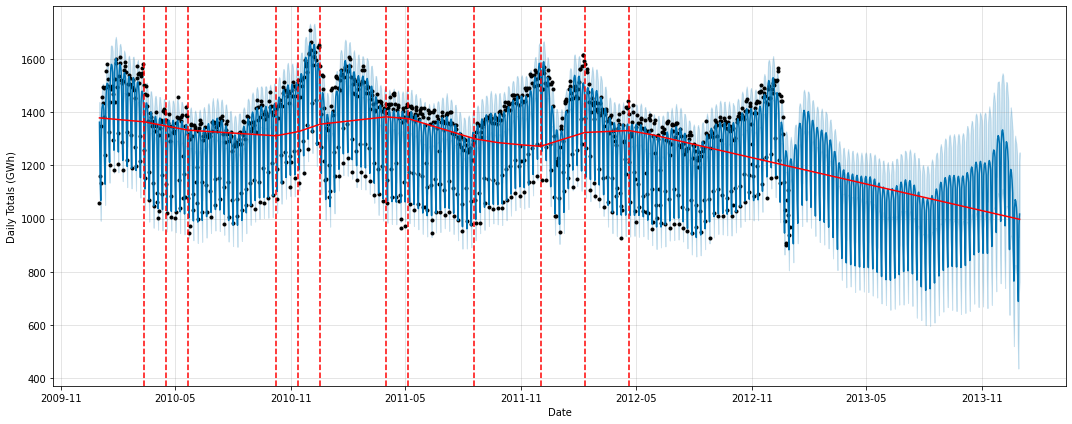

In [64]:
# seanonality 비중을 높인 그래프 출력
fig2 = m2.plot(forecast, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')
a2 = add_changepoints_to_plot(fig2.gca(), m2, forecast2)

###### **a) Custom seasonality**

(Monthly는 기본 속성에 없음)


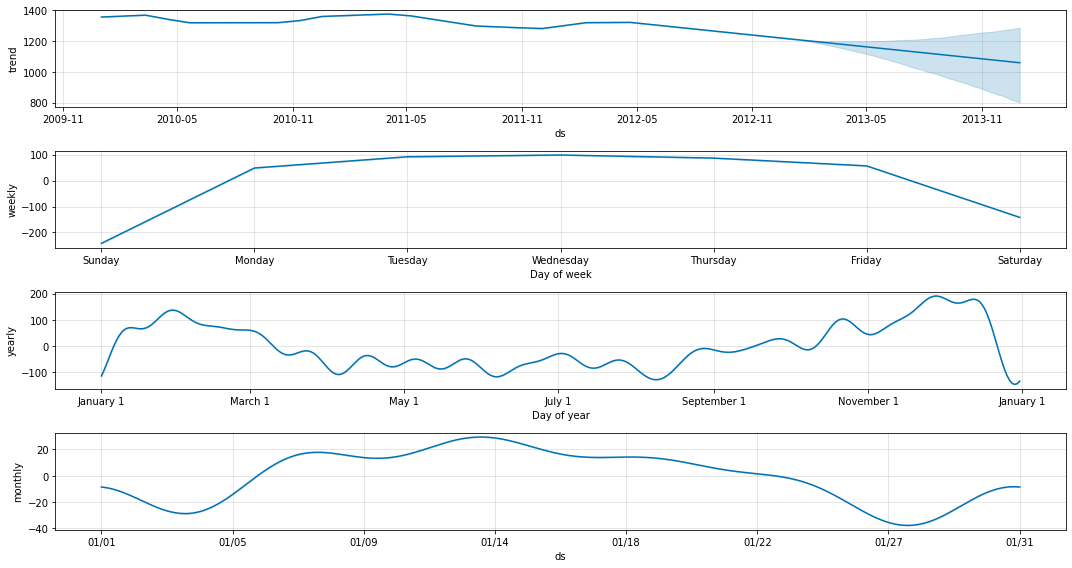

In [65]:
m3 = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=3,  # (default= 3)
    yearly_seasonality=20, # (default= 10)
    daily_seasonality=False
)

# Monthly 추가 
#   (30.4166 ~= 365일 / 12개월)
m3.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m3.fit(df0)
forecast3 = m3.predict(future)

fig3 = m3.plot_components(forecast3, figsize= (15, 8))

*(참고)* 기본 모델의 그래프

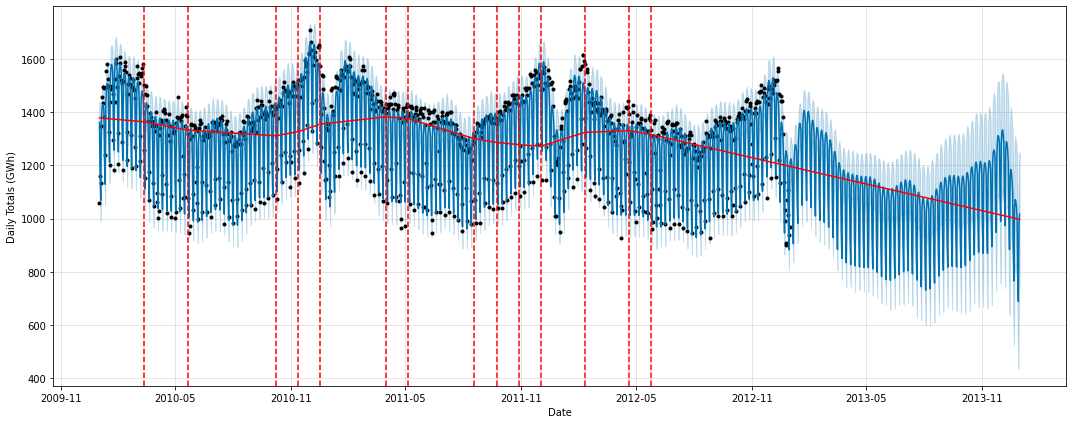

In [66]:
# 기본모델의 그래프 출력
fig = m.plot(forecast, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Custom seasonality (i.e., Monthly) 추가하기 전의 경우와 changepoint 차이가 거의 없음.

→ 현재 데이터는 monthly와 같은 특성이 드러나지 않으므로, monthly를 새롭게 추가할 이유가 부족함.

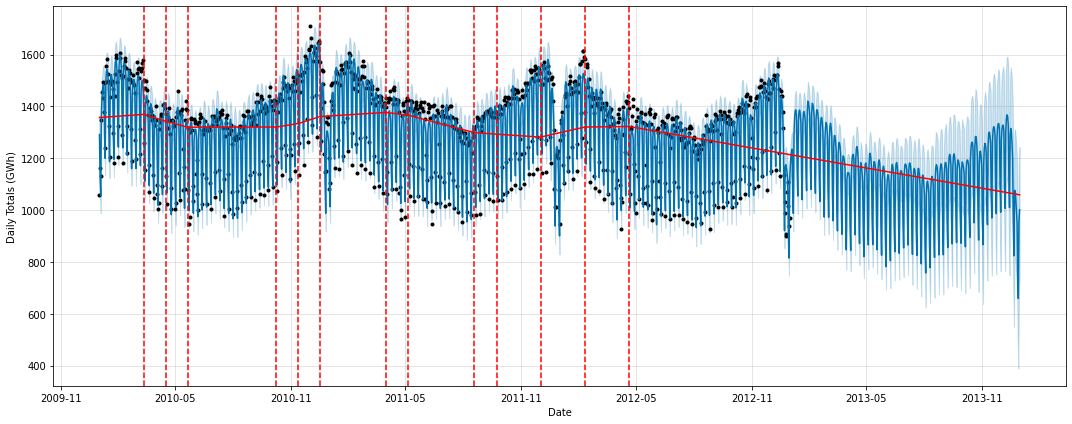

In [67]:
# 예측결과 그래프 출력
fig3 = m3.plot(forecast3, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')
a3 = add_changepoints_to_plot(fig3.gca(), m3, forecast3)

###### **b) Seasonality의 유형 비교** (**`additive`** vs. **`multiplicative`**)

 ![comparison on seaonality types](https://hyperconnect.github.io/assets/2020-03-10-prophet-package/pic12.png)

*   Additive Seasonality : 
  - `Time series = Trend + Seasonality + Error`
*   Multiplicative Seasonality : 
  - `Time series = Trend * Seasonality * Error`



In [68]:
 # seaonality 유형을 'multiplicative'로 변경한 모델 생성
 m4 = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False,
    seasonality_mode='multiplicative' # (default= 'additive')
)

m4.fit(df0)

forecast4 = m4.predict(future)


현재 시계열 데이터 OPSD의 특성은 'multiplicative'가 아니기 때문에, 상당히 부적합한 모델이 생성됨.

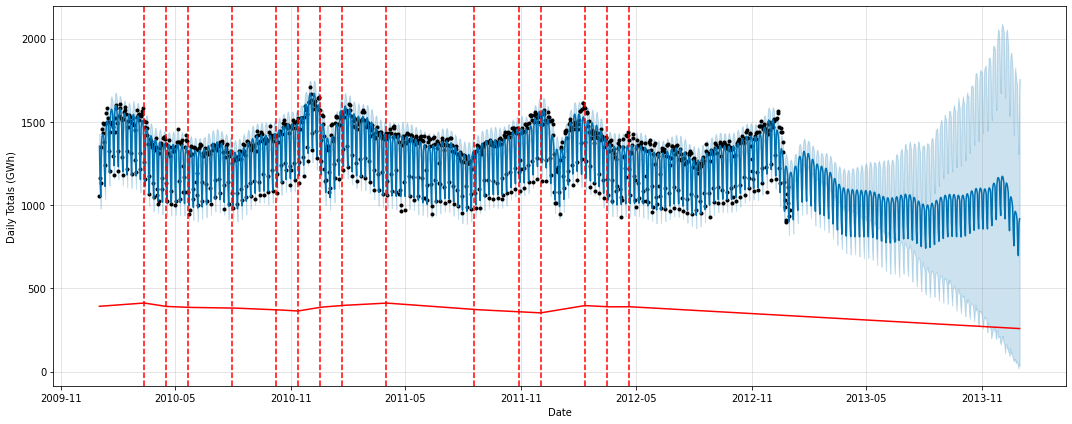

In [69]:
fig4 = m4.plot(forecast4, 
             figsize= (15, 6), 
             xlabel= 'Date', 
             ylabel= 'Daily Totals (GWh)')
a4 = add_changepoints_to_plot(fig4.gca(), m4, forecast4)

#### 인터랙티브 그래프 (plot_plotly 모듈)


`plot_plotly` 모듈을 활용하면, 출력된 그래프의 일부분을 zoom-in 또는 shift 하면서 자세한 관찰이 가능함.

*   기본 옵션 : 1주일(`1w`), 1개월(`1m`), 6개월(`6m`), 1년(`1y`), 전체(`all`)
*   하단 슬라이드 바 영역을 통해서 상세범위를 조작할 수 있음.


In [70]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [71]:
# 예측결과 그래프 출력
fig = plot_plotly(m, 
                  forecast, 
                  figsize=(1200, 600))
py.iplot(fig)

In [72]:
# trend 변화정보와 함께 예측결과 그래프 출력
fig = plot_plotly(m, 
                  forecast, 
                  figsize=(1000, 600), 
                  trend=True, 
                  changepoints=True)
py.iplot(fig)

#### 성능 평가 (MSE, MAPE 등)

##### **(0) 전체 데이터셋 적용**

`Prophet` 모델의 성능평가를 위해서, OPSD 데이터셋 전체를 사용하여 다시 `fit()` 수행함.

In [73]:
# 신규 객체
df_test = pd.DataFrame()

# 전체 기간에서 'Consumption' 데이터만 발췌
df_test['ds'] = df_opsd.index
df_test['y'] = df_opsd['Consumption'].values

df_test.tail()

ds           y
4378 2017-12-27  1263.94091
4379 2017-12-28  1299.86398
4380 2017-12-29  1295.08753
4381 2017-12-30  1215.44897
4382 2017-12-31  1107.11488

In [74]:
# Prophet 모델 생성
m_test = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,  # (default= 3)
    yearly_seasonality=30, # (default= 10)
    daily_seasonality=False
)

m_test.fit(df_test)


In [75]:
# 미래 예측할 날짜범위 생성 (i.e., 다음 1년 분량)
future_test = m_test.make_future_dataframe(periods=365)
future_test.tail()

ds
4743 2018-12-27
4744 2018-12-28
4745 2018-12-29
4746 2018-12-30
4747 2018-12-31

In [76]:
# 예측 수행
forecast_test = m_test.predict(future_test)

# trend 변화정보와 함께 예측결과 그래프 출력
fig_test = plot_plotly(m_test, 
                  forecast_test, 
                  figsize=(1000, 600), 
                  trend=True, 
                  changepoints=True)
py.iplot(fig_test)

##### **(1) cross validation 프로시저**

This `cross validation` procedure can be done automatically for a range of historical cutoffs using the `cross_validation` function. 

![CV of Prophet](https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_4_0.png)

*   The <u>forecast horizon</u> (`horizon`), 
*   and then optionally the <u>size of the initial training period</u> (`initial`) 
*   and the <u>spacing between cutoff dates</u> (`period`). 

By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

`Prophet`에서 제공하는 평가 모듈 `diagnostics`에서 교차검증 `cross_validation` 함수를 임포트

In [77]:
%%time
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(m_test, 
                         initial='730 days', 
                         period='180 days', 
                         horizon = '365 days')

INFO:fbprophet:Making 19 forecasts with cutoffs between 2008-02-17 00:00:00 and 2016-12-31 00:00:00



CPU times: user 2min 18s, sys: 43.1 s, total: 3min 2s
Wall time: 2min 15s


In [78]:
df_cv.head()

ds         yhat   yhat_lower   yhat_upper         y     cutoff
0 2008-02-18  1459.516563  1394.188561  1527.213236  1560.866 2008-02-17
1 2008-02-19  1494.416211  1425.424951  1558.694790  1554.795 2008-02-17
2 2008-02-20  1504.330793  1446.706004  1568.883270  1551.603 2008-02-17
3 2008-02-21  1498.828140  1438.218686  1565.326257  1571.934 2008-02-17
4 2008-02-22  1480.411891  1411.297918  1545.374922  1606.299 2008-02-17

In [79]:
%%time
cutoffs = pd.to_datetime(['2009-04-15', '2011-08-15', '2014-06-15'])
df_cv2 = cross_validation(m_test, 
                          cutoffs=cutoffs, 
                          horizon='365 days')


CPU times: user 20.8 s, sys: 6.96 s, total: 27.7 s
Wall time: 20.2 s


In [80]:
df_cv2.head()

ds         yhat   yhat_lower   yhat_upper         y     cutoff
0 2009-04-16  1199.007250  1125.386522  1270.451824  1251.391 2009-04-15
1 2009-04-17  1184.697146  1116.213907  1253.941954  1257.100 2009-04-15
2 2009-04-18  1012.045876   939.735300  1085.559416  1078.327 2009-04-15
3 2009-04-19   925.728915   855.410628   995.483170   944.848 2009-04-15
4 2009-04-20  1223.130162  1151.933066  1291.024237  1232.893 2009-04-15

##### **(2) Performance Metrics**

*   `MSE`: mean squared error
*   `RMSE`: root mean squared error
*   `MAE`: mean absolute error
*   `MAPE`: mean absolute percent error
*   `MdAPE`: median absolute percent error
*   `Coverage`: coverage of the upper and lower intervals

In [81]:
from fbprophet.diagnostics import performance_metrics

# 첫번째 cross validation 결과의 성능
df_p = performance_metrics(df_cv)
df_p.head()

horizon          mse       rmse        mae      mape     mdape  coverage
0 37 days  3090.352282  55.590937  42.224330  0.030952  0.025094  0.829118
1 38 days  3072.131146  55.426809  42.063039  0.030830  0.025094  0.830561
2 39 days  3085.642519  55.548560  42.055239  0.030857  0.025064  0.828359
3 40 days  3107.703679  55.746782  42.090802  0.030918  0.025064  0.828435
4 41 days  3085.444097  55.546774  42.022917  0.030897  0.025094  0.830637

In [82]:
# 두 번째 cross validation 결과의 성능
df_p2 = performance_metrics(df_cv2)
df_p2.head()

horizon          mse       rmse        mae      mape     mdape  coverage
0 37 days  4877.870515  69.841753  52.424588  0.043574  0.029545  0.770642
1 38 days  4855.272193  69.679783  52.339153  0.043552  0.029176  0.776758
2 39 days  4912.218318  70.087219  52.929981  0.044169  0.028669  0.770642
3 40 days  4893.455890  69.953241  53.404437  0.044504  0.029176  0.758410
4 41 days  4991.467879  70.650321  54.085920  0.045049  0.029545  0.752294

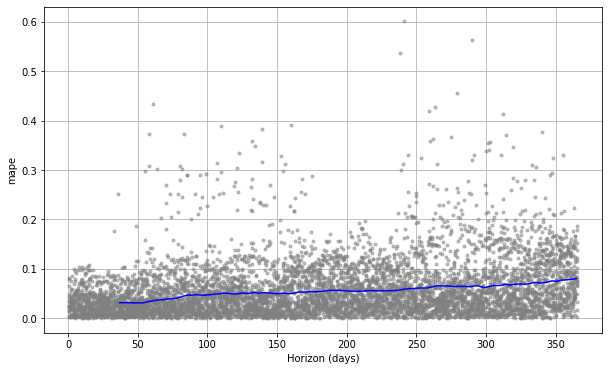

In [83]:
from fbprophet.plot import plot_cross_validation_metric

# 첫번째 결과의 MAPE 시각화
fig = plot_cross_validation_metric(df_cv, metric='mape')

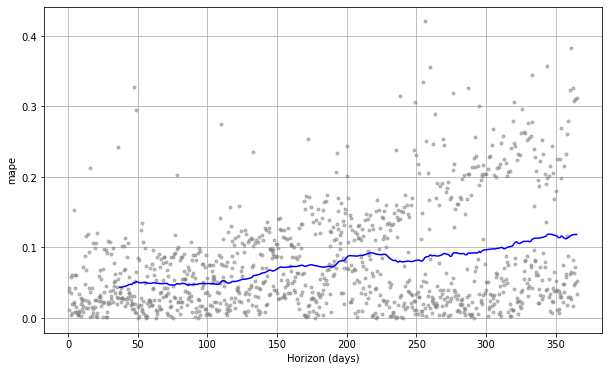

In [84]:

# 두 번째 결과의 MAPE 시각화
fig2 = plot_cross_validation_metric(df_cv2, metric='mape')

## **3. Neural network 모델을 통한 시계열 데이터 처리**

Tensorflow를 활용하여 다음과 같은 내용을 수행함.


#### 필요한 모듈 임포트

In [85]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#### 데이터 로드 및 전처리

*(참고)* OPSD 데이터셋 중 일부 발췌 (2012년~2014년)

In [87]:
df2 = df_opsd.loc['20120101':'20141231', ['Consumption', 'Wind']]

df2

Consumption     Wind
Date                            
2012-01-01      948.128  227.465
2012-01-02     1269.581  207.327
2012-01-03     1334.745  473.468
2012-01-04     1347.136  499.804
2012-01-05     1376.658  523.851
...                 ...      ...
2014-12-27     1198.834  249.906
2014-12-28     1168.079  137.846
2014-12-29     1316.093  148.966
2014-12-30     1300.367  121.775
2014-12-31     1183.510  145.511

[1096 rows x 2 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19bea8c110>,
      dtype=object)

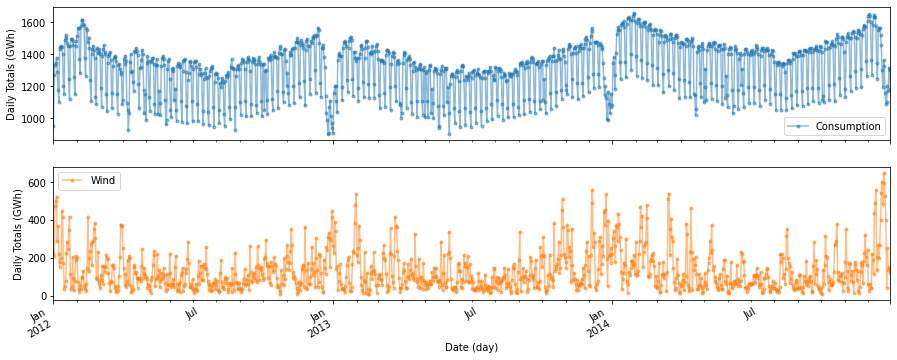

In [88]:
df2.plot(figsize= (15, 6), 
         marker= '.', 
         xlabel= 'Date (day)',
         ylabel= 'Daily Totals (GWh)',
         subplots=True,
#         linestyle='None', 
         alpha=0.5)

'Consumption' 데이터를 학습셋으로 사용

In [89]:
# 'Consumption' 데이터를 학습셋으로 사용
training_set = df2.loc[:, 'Consumption'].values

print('training_set.shape= ' + str(training_set.shape))
print(training_set)

training_set.shape= (1096,)
[ 948.128 1269.581 1334.745 ... 1316.093 1300.367 1183.51 ]


In [90]:
# 다음 단계에서, MinMaxScaler 적용할 수 있는 형태로 shape를 변형
training_set = training_set.reshape(-1, 1)

print('training_set.shape= ' + str(training_set.shape))
print(training_set)

training_set.shape= (1096, 1)
[[ 948.128]
 [1269.581]
 [1334.745]
 ...
 [1316.093]
 [1300.367]
 [1183.51 ]]


Neural network 모델에 시계열 데이터를 입력하려면, input vector의 구조를 설계해야 함.

아래와 같이 `sliding_window()` 함수를 정의하여 사용함.


In [91]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

feature마다 최대/최소값 범위가 다르기 때문에, `[0, 1]` 범위로 정규화(normalization)를 적용함.

*   `MinMaxScaler` : Transform features by scaling each feature to a given range (default= `[0, 1]`).

In [92]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

In [93]:
training_data

array([[0.06354283],
       [0.4864333 ],
       [0.5721604 ],
       ...,
       [0.54762259],
       [0.5269341 ],
       [0.37320179]])

`sliding_window()` 함수를 적용하여 학습 데이터셋을 생성

In [94]:
n_steps_in = 4    # 입력 윈도우 크기
n_steps_out = 1   # 출력 개수
n_features = 1    # Tensor 구성을 위한 featrue dimension 상수값

In [95]:
x, y = sliding_windows(training_data, n_steps_in)

x.shape, y.shape

((1091, 4, 1), (1091, 1))

In [96]:
# 입력 데이터를 Tensor 형태로 reshape
# X_train = x.reshape(x.shape[0], x.shape[1], n_features)

# 마지막 1년 분량 전까지 선택 → training set
X_train = x[:-365]
Y_train = y[:-365]

# 마지막 1년 분량의 데이터만 선택 → validation set
X_test = x[-365:]
Y_test = y[-365:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((726, 4, 1), (726, 1), (365, 4, 1), (365, 1))

In [97]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

### **Simple RNN**

#### 모델 정의


In [98]:
model = Sequential()

# one layer SimpleRNN seems to be enough for this data set
model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features)))

# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


#### 모델 학습


In [99]:
%%time
batch_size = 32
epochs= 50

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/50
23/23 [==============================] - 4s 28ms/step - loss: 0.1345 - mean_absolute_error: 0.3004 - val_loss: 0.0415 - val_mean_absolute_error: 0.1910
Epoch 2/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0348 - mean_absolute_error: 0.1595 - val_loss: 0.0294 - val_mean_absolute_error: 0.1504
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0258 - mean_absolute_error: 0.1327 - val_loss: 0.0253 - val_mean_absolute_error: 0.1421
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0221 - mean_absolute_error: 0.1219 - val_loss: 0.0295 - val_mean_absolute_error: 0.1467
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0199 - mean_absolute_error: 0.1137 - val_loss: 0.0242 - val_mean_absolute_error: 0.1296
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0181 - mean_absolute_error: 0.1061 - val_loss: 0.0174 - val_mean_absolute_error: 0.1050
Epoch 7/50
23/23 [=========

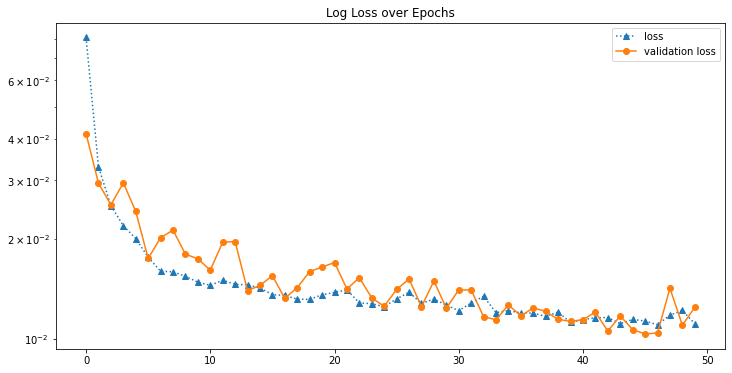

In [100]:
# Loss 히스토리 시각화
plt.figure(figsize= (12, 6))
plt.yscale('log')
plt.plot(history.history['loss'], '^:')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss'])

####성능 평가

`evaluate()` 함수로 학습모델의 전체적인 성능 확인이 가능함.

In [101]:
# 학습모델의 전체 성능
model.evaluate(x, y, batch_size=batch_size)

35/35 [==============================] - 0s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0817


[0.012052818201482296, 0.0816824659705162]

`predict()` 함수로 학습모델을 이용하여 전체 데이터셋의 prediction을 수행함.

In [102]:
Y_pred = model.predict(x)

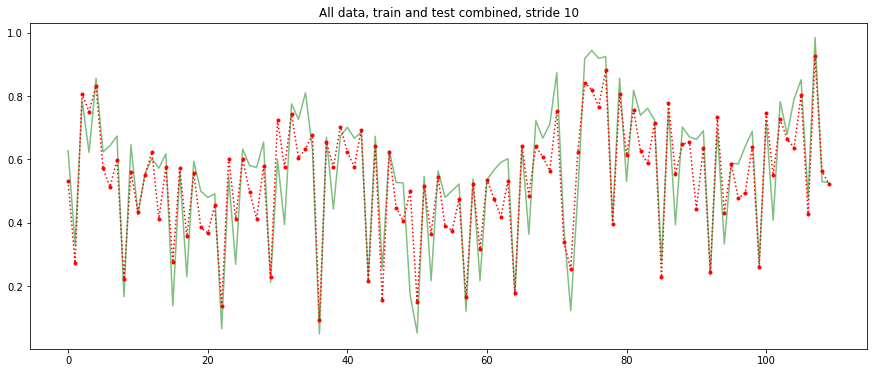

In [103]:
# 출력할 데이터포인트 간격
stride = 10

plt.figure(figsize= (15, 6))

# 앞부분 `n_steps_in`만큼의 데이터는 스킵
plt.plot(training_data[n_steps_in::stride], '-', alpha=0.5, color='g')
plt.plot(Y_pred[::stride], '.:', color='r')

plt.title('All data, train and test combined, stride 10');

### **LSTM**

#### 모델 정의


In [104]:
model = Sequential()

# single LSTM
model.add(LSTM(256, activation='relu', input_shape=(n_steps_in, n_features)))

# two LSTMs
#model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#model.add(LSTM(64, activation='relu'))

# two layer model, known to work well
#model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#model.add(GRU(100, activation='relu'))

# trains faster, but also works
#model.add(GRU(256, activation='relu', input_shape=(n_steps_in, n_features)))

# optional regularization
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


#### 모델 학습


In [105]:
%%time
batch_size = 32
epochs= 50

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/50
23/23 [==============================] - 2s 23ms/step - loss: 0.1970 - mean_absolute_error: 0.3930 - val_loss: 0.0579 - val_mean_absolute_error: 0.1914
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0470 - mean_absolute_error: 0.1757 - val_loss: 0.0585 - val_mean_absolute_error: 0.2266
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0426 - mean_absolute_error: 0.1825 - val_loss: 0.0562 - val_mean_absolute_error: 0.2218
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0415 - mean_absolute_error: 0.1830 - val_loss: 0.0493 - val_mean_absolute_error: 0.2074
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0397 - mean_absolute_error: 0.1730 - val_loss: 0.0465 - val_mean_absolute_error: 0.2002
Epoch 6/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0354 - mean_absolute_error: 0.1608 - val_loss: 0.0530 - val_mean_absolute_error: 0.2115
Epoch 7/50
23/23 [====

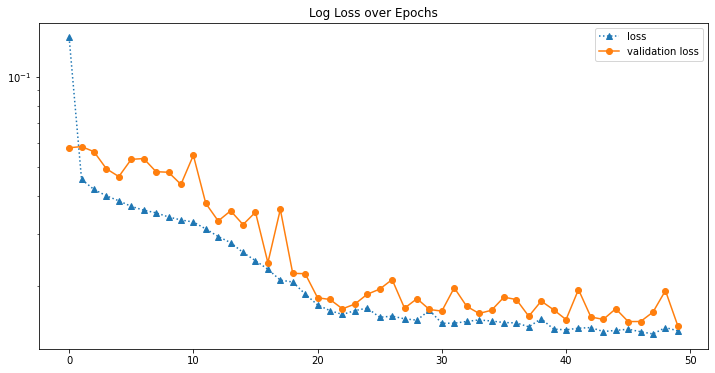

In [106]:
# Loss 히스토리 시각화
plt.figure(figsize= (12, 6))
plt.yscale('log')
plt.plot(history.history['loss'], '^:')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss'])

####성능 평가

`evaluate()` 함수로 학습모델의 전체적인 성능 확인이 가능함.

In [107]:
# 학습모델의 전체 성능
model.evaluate(x, y, batch_size=batch_size)

35/35 [==============================] - 0s 2ms/step - loss: 0.0139 - mean_absolute_error: 0.0822


[0.013934719376266003, 0.08215650171041489]

`predict()` 함수로 학습모델을 이용하여 전체 데이터셋의 prediction을 수행함.

In [108]:
Y_pred = model.predict(x)

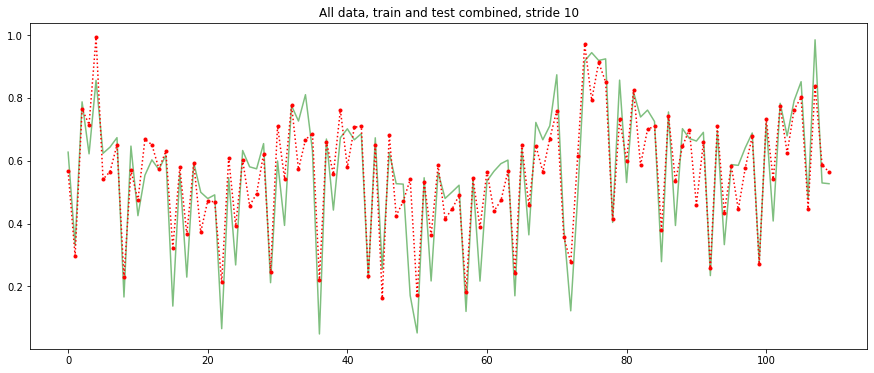

In [109]:
# 출력할 데이터포인트 간격
stride = 10

plt.figure(figsize= (15, 6))

# 앞부분 `n_steps_in`만큼의 데이터는 스킵
plt.plot(training_data[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], '.:', color='r')

plt.title('All data, train and test combined, stride 10');

## **Homework 2**

**※ 제출방법:** 실습내용 및 출력 결과가 저장된 Colab 파일(*.ipynb)를 KLMS의 과제 항목에 업로드

### (1) 새로운 시계열 데이터로 모델 학습하기

아래의 다른 데이터셋을 대상으로, `Prophet` 모듈을 사용해서 자유롭게 학습하고, 예측 결과를 확인합니다. 

*   목표: 
  - 데이터셋에서 임의의 기간을 발췌 (최소 100년 이상 추천)
  - 원하는 파라미터를 사용하여 `Prophet`을 구성하여 학습
  - <u>향후 20년 기간</u>의 예측을 수행
  - 학습결과에 대해서, trend를 확인할 그래프 시각화

#### *Monthly Sunspot Dataset*

This dataset describes **a monthly count of <u>the number of observed sunspots</u>** for just over 230 years (1749-1983).

The units are a count and there are <u>2,820 observations</u>. The source of the dataset is credited to *Andrews & Herzberg (1985)*.

![Dataset of Monthly Sunspots](https://machinelearningmastery.com/wp-content/uploads/2016/11/Monthly-Sun-Spot-Dataset.png)


In [3]:
url_sunspot = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'

!curl -r 0-199 {url_sunspot}

"Month","Sunspots"
"1749-01",58.0
"1749-02",62.6
"1749-03",70.0
"1749-04",55.7
"1749-05",85.0
"1749-06",83.5
"1749-07",94.8
"1749-08",66.3
"1749-09",75.9
"1749-10",75.5
"1749-11",158.6
"17

##### *코드 작성영역*


In [111]:
######
## 2장 내용을 참조해서 작성하세요.
######






### (2) Neural network 실습결과와 비교하여, 성능이 개선된 모델 학습하기

위 3장 실습에서 사용한 것과 같은 데이터를 대상으로, `model.evaluate()`의 성능이 좋은(=loss, error 값이 더 낮은) 모델을 자유롭게 구성합니다. 

*   성능 기준:  LSTM 모델(256, 1-layer)의 결과
  - `loss: 0.0143`
  - `mean_absolute_error: 0.0880`
*   대상 데이터: 
  - OPSD 데이터셋 중 일부 발췌 (2012년~2014년)
  - `Consumption` 컬럼을 사용

##### *코드 작성영역*


In [ ]:
######
## 3장 내용을 참조해서 작성하세요.
######






### (3) OPSD 데이터셋의 다른 컬럼에 대한 추가 실험하기

위 3장 실습에서 사용한 것과 같은 데이터를 대상으로, 다른 패턴을 가진 데이터 컬럼을 학습하기 위한 모델을 구성해보고, 학습결과에 대한 해석을 합니다.

*   대상 데이터: 
  - OPSD 데이터셋 중 기간 범위는 임의 선택할 것 (최소 2년 이상 추천)
  - `Wind, Solar` 컬럼을 사용
*   목표:
  - <u>동일한 학습모델</u>을 구성한 후, `Wind, Solar` 컬럼을 각각 학습시킴
  - 학습과정의 히스토리 시각화 출력
  - `evaluate()` 결과값 출력
  - 다른 데이터 컬럼에서 <u>학습한 결과에 대한 해석</u>을 수행함 (자유 의견, 최소 2줄 이상)

#### (3-a) OPSD 데이터셋에서 `Wind` 컬럼을 사용



##### *코드 작성영역*


In [ ]:
######
## 3장 내용을 참조해서 작성하세요.
######






#### (3-b) OPSD 데이터셋에서 `Solar` 컬럼을 사용

**※ 주의:** 위 3-a 단계와 동일한 모델 구성으로 학습한 후, 결과해석을 할 것임.

##### *코드 작성영역*


In [ ]:
######
## 위 3-a 단계의 모델을 똑같이 사용해서 작성하세요.
######






#### (3-c) 위에서 실험한 결과에 근거하여, `Wind` 및 `Solar` 컬럼의 학습결과 해석

*   <u>학습한 결과에 대한 해석</u>을 수행함. (자유 의견, 최소 2줄 이상)
  - Case 1) 비슷한 결과였다면, 어떤 시계열 데이터의 특성에 영향을 받은 결과였을지?
  - Case 2) 다른 수준이 나타났다면, 어떤 시계열 특성 때문에 동일 모델임에도 성능 차이가 발생했을지?

##### *답변 작성영역*


In [ ]:
######
## 학습결과에 대한 해석을 작성하세요. (텍스트 블록 추가해서 작성해도 됨.)
######

- 내용 작성 ~~~
- 내용 작성 ~~~



## **4. `Prophet`을 활용한 anomaly detection**

---
<br />

#### &nbsp;&nbsp; *References*

*   `Altair` Hompage. <small>https://altair-viz.github.io/</small>
*   Insaf Ashrapov, "Anomaly detection in time series with Prophet library," Jun. 4, 2019. <small>https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f</small>

##### 데이터 준비

In [1]:
from fbprophet import Prophet

# `ds`, `y` 컬럼으로 구성된 DataFrame 생성
def make_df_prophet(src_df, col_name):
  df = pd.DataFrame()
  df['ds'] = src_df.index.values
  df['y'] = src_df[col_name].values

  return df

In [2]:
df1 = make_df_prophet(df_opsd, 'Consumption')
df2 = make_df_prophet(df_opsd, 'Wind')
df3 = make_df_prophet(df_opsd, 'Solar')

df1.tail()

NameError: ignored

##### `fit_predict_model()` 함수 정의

*   `Prophet` 모델 생성 후, 같은 데이터에 대해서 self-prediction 수행
*   목적: yhat_lower, _upper 와 같은 `uncertainty interval`을 계산

In [114]:
def fit_predict_model(dataframe, interval_width= 0.99, yearly_seasonality= False, weekly_seasonality= False):
    m = Prophet(daily_seasonality= False, 
                weekly_seasonality= weekly_seasonality, 
                yearly_seasonality= yearly_seasonality, 
                seasonality_mode= 'multiplicative', 
                # `uncertainty interval` 기준으로 anomaly를 체크할 것
                # 최대한의 범위를 잡아주기 위해서 0.99 지정
                interval_width= interval_width)
    m = m.fit(dataframe)

    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].values

    return forecast

In [115]:
fit_predict_model(df1).tail()

ds        trend  ...         yhat        fact
4378 2017-12-27  1382.403013  ...  1382.403013  1263.94091
4379 2017-12-28  1382.404176  ...  1382.404176  1299.86398
4380 2017-12-29  1382.405339  ...  1382.405339  1295.08753
4381 2017-12-30  1382.406501  ...  1382.406501  1215.44897
4382 2017-12-31  1382.407664  ...  1382.407664  1107.11488

[5 rows x 14 columns]

##### `detect_anomalies()` 함수 정의

*   모델에서 예측한 `uncertainty interval`을 기준으로 anomaly 체크<br /> (`yhat_upper`를 초과하면 "1"; `yhat_lower` 미만이면 "-1")


In [ ]:
def detect_anomalies(src_forecast):
    forecasted = src_forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    # 주어진 컬럼 중에서, forecast['fact'] == df['y']

    # anomaly detection (`uncertainty interval`을 벗어나는 경우를 체크)
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    # anomaly importances (범위를 크게 벗어나면 높은 값)
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper']) / src_forecast['fact']
    forecasted.loc[forecasted['anomaly'] == -1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact']) / src_forecast['fact']
    
    return forecasted

In [ ]:
tmp = fit_predict_model(df1)
detect_anomalies(tmp).tail()

##### `plot_anomalies()` 함수 정의

*    `Altair` 라이브러리 활용한 시각화 기능을 구현 <br />(i.e., y, anomaly, interval) 
  - `Altair` is a <u>declarative statistical visualization</u> library for Python.


In [ ]:
import altair as alt

In [ ]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate= 'basis', color= '#aabbee', opacity= 0.7).encode(
        x= alt.X('ds:T', title= 'Date (day)'),
        y= 'yhat_upper',
        y2= 'yhat_lower',
        tooltip= ['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )
    
    trend = alt.Chart(forecasted).mark_line(color= 'darkorange', opacity= 0.7).encode(
        x= 'ds:T',
        y= 'trend',
        tooltip= ['ds', 'trend']
    ).interactive()

    fact = alt.Chart(forecasted[forecasted.anomaly == 0]).mark_circle(size= 15, color= 'Black', opacity= 0.5).encode(
        x= 'ds:T',
        y= alt.Y('fact', title= 'Daily Totals (GWh)'),    
        tooltip= ['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly != 0]).mark_circle(size= 30, color= 'Red').encode(
        x= 'ds:T',
        y= alt.Y('fact', title= 'Daily Totals (GWh)'),    
        tooltip= ['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size('importance', legend= None)
    ).interactive()

    return alt.layer(interval, fact, anomalies, trend)\
              .properties(width= 1000, height= 350)\
              .configure_title(fontSize= 20)

##### 타겟 데이터에 anomaly detection 적용

In [ ]:
# `Prophet` 모델 생성 후, 같은 데이터에 대해서 self-prediction 수행
# 목적: yhat_lower, _upper 와 같은 `uncertainty interval`을 계산
pred = fit_predict_model(df1)   # df1 == 'Consumption'

# anomaly 체크 (upper 초과하면 "1"; lower 미만이면 "-1")
pred_ano = detect_anomalies(pred)

# `Altair` 라이브러리 활용한 시각화 (i.e., y, anomaly, interval)
plot_anomalies(pred_ano)

In [ ]:
pred_ano.tail()

In [ ]:
# Anomaly Type:  y > yhat_upper
pred_ano.loc[pred_ano['anomaly'] == 1]

In [ ]:
# Anomaly Type:  y < yhat_lower
pred_ano.loc[pred_ano['anomaly'] == -1]

###### anomaly 통계 요약

*   다음과 같은 요약을 출력하고, 함수의 결과값으로 리턴
  - `ratio_ano`: 전체 데이터 수를 기준으로, 발견된 anomaly들이 차지하는 비율
  - `n_ano_upper`: 모델의 `yhat_upper` 초과하는 anomaly들의 개수
  - `n_ano_lower`: 모델의 `yhat_lower` 미만인 anomaly들의 개수

In [ ]:
def stat_anomalies(pred_ano):
  # Number of anomalies
  n_ano_upper = len(pred_ano.loc[pred_ano['anomaly'] == 1])
  n_ano_lower = len(pred_ano.loc[pred_ano['anomaly'] == -1])

  sum_n_ano = n_ano_upper + n_ano_lower

  # Ratio of anomalies
  ratio_ano = sum_n_ano * 100 / len(pred_ano)

  print('> Total number of datapoints= %d' % len(pred_ano))
  print('> Total number of anomalies= %d  (Ratio= %.02f%%)' % (sum_n_ano, ratio_ano))
  print('  > The number over "yhat_upper" anomalies= %d' % n_ano_upper)
  print('  > The number under "yhat_lower" anomalies= %d' % n_ano_lower)

  return ratio_ano, n_ano_upper, n_ano_lower

In [ ]:
# 현재 발견된 anomaly들의 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

##### anomaly 발견 기준치를 조율

*   원하는 수준의 anomaly가 발견될 수 있도록 `Prophet` 모델 파라미터를 변경 시도

###### (1) `interval_width` 파라미터 (0.99 → 0.95)

In [ ]:
# `Prophet` 모델 생성 후, 같은 데이터에 대해서 self-prediction 수행
pred = fit_predict_model(df1,
                         interval_width=0.95
                         )   # df1 == 'Consumption'

pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

###### (2) `yearly_seasonality` 파라미터 (`False` → 10)

In [ ]:
# `Prophet` 모델 생성 후, 같은 데이터에 대해서 self-prediction 수행
pred = fit_predict_model(df1,
                         yearly_seasonality= 10
                         )   # df1 == 'Consumption'

pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

###### (3) `weekly_seasonality` 파라미터 (`False` → 3)

In [ ]:
# `Prophet` 모델 생성 후, 같은 데이터에 대해서 self-prediction 수행
pred = fit_predict_model(df1,
                         weekly_seasonality= 3
                         )   # df1 == 'Consumption'

pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

## <실습 문제>  &nbsp;&nbsp;&nbsp; <small>← *Homework이 아니므로 개인적으로 확인*</small>

OPSD 데이터의 다른 컬럼들을 대상으로, 특정한 수준의 anomaly detection을 수행해보자.

*   적용대상
  - `df2`: OPSD 데이터의 `Wind` 파트
  - `df3`: OPSD 데이터의 `Solar` 파트
*   힌트
  - 앞서 설명한 바와 같이 `fit_predict_model()` 함수의 파라미터를 조정 가능함.
  - 시계열 데이터 특성에 따라, interval이나 seanonalty의 영향력이 다를 수 있음.

#### <문제 A-1>

*   목표
  - `Wind` 데이터에서 발견된 **anomaly의 비율**을 <u>약 7% 수준</u>으로 조정

In [ ]:
##################################
##  문제에 맞도록 수정할 것!
##################################
pred = fit_predict_model(df2)   # df2 == 'Wind'
pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

#### <문제 A-2>

*   목표
  - `Wind` 데이터에서 발견된 anomaly 중에서 **`yhat_lower` 미만인 개수**를 <u>약 30개 내외</u>로 조정

In [ ]:
##################################
##  문제에 맞도록 수정할 것!
##################################
pred = fit_predict_model(df2)   # df2 == 'Wind'
pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

#### <문제 A-3>

*   목표
  - `Wind` 데이터에서 발견된 **anomaly의 비율**이 <u>약 7% 수준</u>이고, 동시에  **`yhat_lower` 미만인 개수**를 <u>약 60개 내외</u>로 조정

In [ ]:
##################################
##  문제에 맞도록 수정할 것!
##################################
pred = fit_predict_model(df2)   # df2 == 'Wind'
pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

#### <문제 B-1>

*   목표
  - `Solar` 데이터에서 발견된 **anomaly의 비율**이 <u>약 30% 수준</u>으로 조정

In [ ]:
##################################
##  문제에 맞도록 수정할 것!
##################################
pred = fit_predict_model(df3)   # df3 == 'Solar'
pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

#### <문제 B-2>

*   목표
  - `Solar` 데이터에서 발견된 **anomaly의 비율**이 <u>약 30% 수준</u>으로 조정
  - 단, `seasonality`를 반영하여 조정할 것

In [ ]:
##################################
##  문제에 맞도록 수정할 것!
##################################
pred = fit_predict_model(df3)   # df3 == 'Solar'
pred_ano = detect_anomalies(pred)
plot_anomalies(pred_ano)

In [ ]:
# 통계 요약
ratio, n_up, n_lo = stat_anomalies(pred_ano)

## **5. Python Outlier Detection (PyOD) 라이브러리**


`PyOD` is a <u>*comprehensive*</u> and <u>*scalable*</u> Python toolkit for <u>*detecting outlying objects*</u> in multivariate data. 

This exciting yet challenging field is commonly referred as [Outlier Detection](https://en.wikipedia.org/wiki/Anomaly_detection) or [Anomaly Detection](https://en.wikipedia.org/wiki/Anomaly_detection).

`PyOD` includes more than 30 detection algorithms, from classical LOF (SIGMOD 2000) to the latest COPOD (ICDM 2020).



---
<br />

#### &nbsp;&nbsp; *References*

*   `PyOD` Github. <small>https://github.com/yzhao062/pyod</small>
*   Lakshay Arora, "An Awesome Tutorial to Learn Outlier Detection in Python using PyOD Library," Feb. 14, 2019. <small>https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/</small>



In [ ]:
!pip install pyod
!pip install combo

In [ ]:
X_train = df1.iloc[:731, 1].to_numpy().reshape(-1, 1)
X_test = df1.iloc[731:, 1].to_numpy().reshape(-1, 1)

#### PyOD 튜토리얼 - Part A

##### **Angle-Based Outlier Detection (ABOD)**
https://dl.acm.org/doi/pdf/10.1145/1401890.1401946

*   It considers the relationship between each point and its neighbor(s). 
  - It does not consider the relationships among these neighbors. 
  - The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score
*   ABOD performs well on multi-dimensional data
*   PyOD provides two different versions of ABOD:
  - **Fast ABOD**: Uses k-nearest neighbors to approximate
  - **Original ABOD**: Considers all training points with high-time complexity

<br />

##### **k-Nearest Neighbors (kNN) Detector**
https://dl.acm.org/doi/pdf/10.1145/342009.335437

*   For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score
*   PyOD supports three kNN detectors:
  - **Largest**: Uses the distance of the kth neighbor as the outlier score
  - **Mean**: Uses the average of all k neighbors as the outlier score
  - **Median**: Uses the median of the distance to k neighbors as the outlier score

<br />

필요한 모듈 임포트

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

In [ ]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

분석 데이터를 랜덤하게 생성

In [ ]:
from pyod.utils.data import generate_data, get_outliers_inliers

#generate random data with two features
X_train, Y_train = generate_data(n_train= 200, 
                                 train_only= True, 
                                 n_features= 2)

# by default the outlier fraction is 0.1 in generate data function 
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,
                                             Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

# separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), 
                      np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1, F2)
plt.xlabel('F1')
plt.ylabel('F2') 

PyOD를 사용하여 outlier detection 수행

In [ ]:
classifiers = {
     'Angle-based Outlier Detector (ABOD)': ABOD(contamination= outlier_fraction),
     'k-Nearest Neighbors (kNN)': KNN(contamination= outlier_fraction)
}

In [ ]:
%%time
#set the figure size
plt.figure(figsize= (15, 7))

for i, (clf_name, clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train) * -1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ', clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,
                                        100 * outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, 
                     levels= np.linspace(Z.min(), threshold, 10),
                     cmap= plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, 
                        levels= [threshold],
                        linewidths= 2, 
                        colors= 'red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, 
                     levels= [threshold, Z.max()],
                     colors= 'orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], 
                        X_train[:-n_outliers, 1], 
                        c= 'white',
                        s= 20, 
                        edgecolor= 'k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], 
                        X_train[-n_outliers:, 1], 
                        c= 'black',
                        s= 20, 
                        edgecolor= 'k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop= matplotlib.font_manager.FontProperties(size= 10),
        loc= 'lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 

#### PyOD 튜토리얼 - Part B

##### **AutoEncoder**
*(Book) Aggarwal, C.C., 2015. Outlier analysis. In Data mining (pp. 237-263). Springer, Cham.*

*   use reconstruction error as the outlier score

##### **Variational AutoEncoder**
https://arxiv.org/pdf/1312.6114.pdf?source=post_page

*   use reconstruction error as the outlier score

AutoEncoder를 적용한 분석

In [ ]:
%%time
from pyod.utils.data import evaluate_print
from pyod.models.auto_encoder import AutoEncoder

contamination = 0.1  # percentage of outliers
n_train = 20000  # number of training points
n_test = 2000  # number of testing points
n_features = 300  # number of features

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=n_features,
                  contamination=contamination,
                  random_state=42)

# train AutoEncoder detector
clf_name = 'AutoEncoder'
clf = AutoEncoder(epochs=10, contamination=contamination)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Variational AutoEncoder를 적용한 분석

In [ ]:
%%time
from pyod.utils.data import evaluate_print
from pyod.models.vae import VAE

contamination = 0.1  # percentage of outliers
n_train = 20000  # number of training points
n_test = 2000  # number of testing points
n_features = 300  # number of features

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=n_features,
                  contamination=contamination,
                  random_state=42)

# train VAE detector (Beta-VAE)
clf_name = 'VAE'
clf = VAE(epochs=10, contamination=contamination, gamma=0.8, capacity=0.2)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

#### OPSD 데이터 적용을 위한 튜토리얼 소스코드 변형

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

In [ ]:
df_opsd.plot.scatter('Consumption', 'Wind')

In [ ]:
df_opsd.plot.scatter('Consumption', 'Solar')

In [ ]:
df_opsd.plot.scatter('Wind', 'Solar')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0, 1))

# 대상 데이터 time-series를 2개 선택
name_X1 = 'Consumption'
name_X2 = 'Wind'

# NaN 값 드롭 처리
df = df_opsd.loc[:, [name_X1, name_X2]].dropna()
df[[name_X1, name_X2]] = scaler.fit_transform(df.values)

df.head()

In [ ]:
# 데이터 세팅
X1 = df[name_X1].values.reshape(-1,1)
X2 = df[name_X2].values.reshape(-1,1)

X = np.concatenate((X1, X2), axis=1)

X1.shape, X2.shape, X.shape

PyOD 분석을 위한 설정

In [ ]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05  # Outlier 비율을 5% 지정
#outliers_fraction = 0.15

# Define outlier detection tools to be compared
classifiers = {
      # Type: Probabilistic
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination= outliers_fraction),

      # Type: Proximity-Based
        'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination= outliers_fraction,
                                                            check_estimator= False, 
                                                            random_state= random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination= outliers_fraction),
        'k-Nearest Neighbors (kNN)': KNN(contamination= outliers_fraction),
        # 'Average kNN': KNN(method= 'mean',
        #                    contamination= outliers_fraction),
               
      # Type: Outlier Ensembles
        'Isolation Forest': IForest(contamination= outliers_fraction,
                                    random_state= random_state),
        'Feature Bagging': FeatureBagging(LOF(n_neighbors= 35),
                                          contamination= outliers_fraction,
                                          check_estimator= False,
                                          random_state= random_state),
}

#### Algorithms


##### **Isolation Forest**
https://ieeexplore.ieee.org/document/4781136

*   It uses the scikit-learn library internally. In this method, data partitioning is done using a set of trees. 
  - Isolation Forest provides an anomaly score looking at how isolated the point is in the structure. 
  - The anomaly score is then used to identify outliers from normal observations
*   Isolation Forest performs well on multi-dimensional data

<br />

##### **Histogram-based Outlier Detection (HBOS)**
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.401.5686&rep=rep1&type=pdf

*   It is an efficient unsupervised method which assumes the feature independence and calculates the outlier score by building histograms
It is much faster than multivariate approaches, but at the cost of less precision

<br />

<!--##### **Local Correlation Integral (LOCI)**
https://ieeexplore.ieee.org/iel5/8910/28179/01260802.pdf

*   LOCI is very effective for detecting outliers and groups of outliers. 
  - It provides a LOCI plot for each point which summarizes a lot of the information about the data in the area around the point, determining clusters, micro-clusters, their diameters, and their inter-cluster distances
*   None of the existing outlier-detection methods can match this feature because they output only a single number for each point

<br />-->

##### **Feature Bagging**
https://dl.acm.org/doi/pdf/10.1145/1081870.1081891

*   A feature bagging detector fits a number of base detectors on various sub-samples of the dataset. 
  - It uses averaging or other combination methods to improve the prediction accuracy
*   By default, **Local Outlier Factor (LOF)** is used as the base estimator. 
https://dl.acm.org/doi/pdf/10.1145/342009.335388

  - However, any estimator could be used as the base estimator, such as kNN and ABOD
*   Feature bagging first constructs n sub-samples by randomly selecting a subset of features. 
  - This brings out the diversity of base estimators. 
  - Finally, the prediction score is generated by averaging or taking the maximum of all base detectors

<br />

##### **Clustering Based Local Outlier Factor (CBLOF)**
https://www.sciencedirect.com/science/article/pii/S0167865503000035

*   It classifies the data into small clusters and large clusters. 
  - The anomaly score is then calculated based on the size of the cluster the point belongs to, as well as the distance to the nearest large cluster


#### `plot_pyod_anomaly()` 함수 정의

In [ ]:
def plot_pyod_anomaly(df, clf_name, clf, subplot= None):
  # predict raw anomaly score
  scores_pred = clf.decision_function(X) * -1

  # prediction of a datapoint category outlier or inlier
  y_pred = clf.predict(X)
  n_inliers = len(y_pred) - np.count_nonzero(y_pred)
  n_outliers = np.count_nonzero(y_pred == 1)
  
  # copy of dataframe
  dfx = df
  dfx['outlier'] = y_pred.tolist()
  
  # IX1 - inlier feature 1,  IX2 - inlier feature 2
  IX1 =  np.array(dfx[name_X1][dfx['outlier'] == 0]).reshape(-1,1)
  IX2 =  np.array(dfx[name_X2][dfx['outlier'] == 0]).reshape(-1,1)
  
  # OX1 - outlier feature 1, OX2 - outlier feature 2
  OX1 =  dfx[name_X1][dfx['outlier'] == 1].values.reshape(-1,1)
  OX2 =  dfx[name_X2][dfx['outlier'] == 1].values.reshape(-1,1)
        
  print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
      
  # threshold value to consider a datapoint inlier or outlier
  threshold = stats.scoreatpercentile(scores_pred,
                                      100 * outliers_fraction)
      
  # decision function calculates the raw anomaly score for every point
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
  Z = Z.reshape(xx.shape)
  
  # 서브 플롯이 주어졌는지 여부에 따라서 출력 대상을 변경
  target_plot = plt
  if subplot != None:
    target_plot = subplot

  # fill blue map colormap from minimum anomaly score to threshold value
  target_plot.contourf(xx, yy, Z, 
                   levels= np.linspace(Z.min(), threshold, 7),
                   cmap= plt.cm.Blues_r)
      
  # draw red contour line where anomaly score is equal to thresold
  a = target_plot.contour(xx, yy, Z, 
                      levels= [threshold],
                      linewidths= 2, 
                      colors= 'red')
      
  # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
  target_plot.contourf(xx, yy, Z, 
                   levels= [threshold, Z.max()],
                   colors= 'orange')
      
  b = target_plot.scatter(IX1, IX2, 
                      c= 'white',
                      s= 20, 
                      edgecolor= 'k')
  
  c = target_plot.scatter(OX1, OX2, 
                      c= 'black',
                      s= 20, 
                      edgecolor= 'k')
      
  target_plot.axis('tight')  
  
  # loc=2 is used for the top left corner 
  target_plot.legend(
      [a.collections[0], b,c],
      ['learned decision function', 'inliers','outliers'],
      prop= matplotlib.font_manager.FontProperties(size=10),
      loc= 2)
  
  # 서브 플롯이 주어졌는지 여부에 따라서 출력 대상을 변경
  if subplot != None:
    target_plot.set_xlim((0, 1))
    target_plot.set_ylim((0, 1))
    target_plot.set_title(clf_name)
  else:
    target_plot.xlim((0, 1))
    target_plot.ylim((0, 1))
    target_plot.title(clf_name)

  return target_plot

#### 각각의 anomaly detection을 수행하는 루프

In [ ]:
%%time
# 데이터 세팅
X1 = df[name_X1].values.reshape(-1,1)
X2 = df[name_X2].values.reshape(-1,1)

X = np.concatenate((X1, X2), axis=1)

xx , yy = np.meshgrid(np.linspace(0, 1, 200), 
                      np.linspace(0, 1, 200))

# 각 모델별로 서브 플롯
plt.figure(figsize= (15, 20))
for i, (clf_name, clf) in enumerate(classifiers.items()):
  clf.fit(X)

  # 서브 플롯으로 결과 출력
  subplot = plt.subplot(3, 2, i + 1)
  plot_pyod_anomaly(df, clf_name, clf, subplot)

plt.show()

### *GAN 기반 anomaly detection*

*   Single-Objective Generative Adversarial Active Learning (SO_GAAL)
*   Multiple-Objective Generative Adversarial Active Learning (MO_GAAL)

In [ ]:
# 데이터 세팅
X1 = df[name_X1].values.reshape(-1,1)
X2 = df[name_X2].values.reshape(-1,1)

X = np.concatenate((X1, X2), axis=1)

random_state = np.random.RandomState(42)
outliers_fraction = 0.05  # Outlier 비율을 5% 지정

In [ ]:
def run_pyod_single(df, clf_name, clf):
  clf.fit(X)

  plt.figure(figsize= (10, 10))
  # 싱글 플롯으로 결과 출력
  plot_pyod_anomaly(df, clf_name, clf)
  plt.show()

In [ ]:
%%time
run_pyod_single(df,
                'Single-Objective Generative Adversarial Active Learning (SO_GAAL)',
                SO_GAAL(contamination= outliers_fraction))

In [ ]:
%%time
run_pyod_single(df,
                'Multiple-Objective Generative Adversarial Active Learning (MO_GAAL)',
                MO_GAAL(contamination= outliers_fraction))